# Introduction:
The following project was written by Max Tejera during the spring of 2024 for his Time Series Forecasting course. It seeks to recreate and improve upon how the Colorado Legislative Council Staff forecasts sales tax revenue for the State of Colorado.

The model that was ultimately selected for submission was a Seasonal ARIMA model with decaying policy variables for the pandemic and great financial crisis.

Most of the models attempted appear to struggle with the spike in inflation related to the pandemic.

# Section 0: Setup

Import relevant libraries.

In [1]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tbats import TBATS
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Section 1: Data Import

The following code imports data from a spreadsheet. The spreadsheet contains the following relevant variables:

1. Date: Quaterly frequency from Q3 1991 to Q3 2023.
2. Personal Income (FYPQ): Colorado Personal Income actual and forecast from Moody's.
3. Raw Sales Tax Data (CO): Sales Tax Collections in millions as aggregated from public facing reports by the Colorado Legislative Council Staff data scientist.

The file contains some other variables used by the Colorado Legislative Council Staff economist to forecast sales tax revenue. They have seasonally adjusted sales tax revenue, a dummy variable for the pandemic era, and the national unemployment rate. These variables won't be used in this file as the goal of this file is to improve upon the original model.

In [2]:
# Path to the Excel file
excel_file_path = 'C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\Sales Tax Revenue Forecast\\sales tax model variables.xlsx'

# Import the Excel file, using the first row for headers
df = pd.read_excel(excel_file_path, sheet_name='model x and y variables')

# Check if the first row contains 'DATE' or similar placeholder and handle it
if 'DATE' in df.columns[0].upper():
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)

# Rename the 'raw sales tax data (CO)' column to 'strev' for easier reference
if 'raw sales tax data (CO)' in df.columns:
    df.rename(columns={'raw sales tax data (CO)': 'strev'}, inplace=True)
else:
    # If the column isn't found, print the current column names for review
    print("Check column names for 'strev':", df.columns)

# Convert 'date' column to datetime, handling it as quarterly data
df['date'] = pd.PeriodIndex(df['date'], freq='Q').to_timestamp()

# Drop specified columns if they exist in the DataFrame
columns_to_drop = ['sales_tax_dummy','personal income (fypq)', 'flbr (unemployment rate)', 'seasonally adjusted sales tax data']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Filter out rows with NaN in 'strev' column to ensure clean plotting
df = df.dropna(subset=['strev'])

# Display the first few rows of the cleaned DataFrame to verify changes
print(df.head())

         date  strev
38 2001-01-01  451.9
39 2001-04-01  438.2
40 2001-07-01  465.0
41 2001-10-01  429.2
42 2002-01-01  433.0


The following code imports Total Personal Income in Colorado downloaded from the St. Louis Fed-FRED website here: https://fred.stlouisfed.org/series/COOTOT

This time series is intended to be an improvement over the Moody's time series, which has some forecasted values for more recent observations.

In [3]:
# Path to the COOTOT CSV file
cootot_file_path = 'C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\Sales Tax Revenue Forecast\\COOTOT.csv'

# Read the COOTOT CSV file
cootot_df = pd.read_csv(cootot_file_path)

# Convert 'DATE' column to datetime
cootot_df['DATE'] = pd.to_datetime(cootot_df['DATE'])

# Rename 'DATE' column to 'date' to match the column name in the original df DataFrame
cootot_df.rename(columns={'DATE': 'date'}, inplace=True)

# Merge COOTOT data with df based on the 'date' column
df = pd.merge(df, cootot_df, on='date', how='left')

# Display the first few rows of the merged DataFrame to verify changes
print(df.head())

        date  strev    COOTOT
0 2001-01-01  451.9  154657.2
1 2001-04-01  438.2  154907.4
2 2001-07-01  465.0  153611.9
3 2001-10-01  429.2  153090.5
4 2002-01-01  433.0  152796.5


# Section 2: Data and Considerations

The State of Colorado publishes the relevant table on the State's sales tax:

https://tax.colorado.gov/sites/tax/files/DR1250_2019.pdf

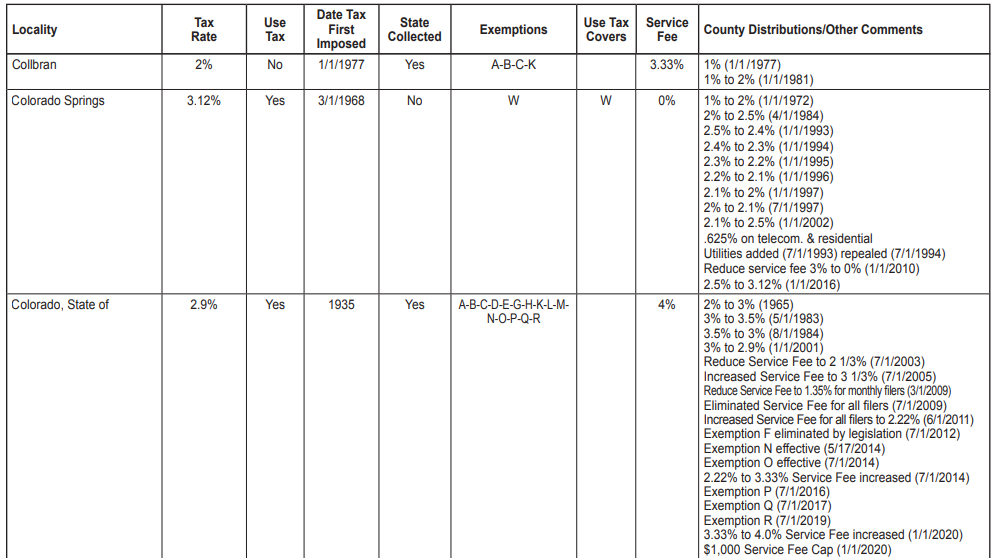

From the table it can be seen that the sales tax rate transitioned from 3% to 2.9% beginning in 2001. It hasn't changed since.

The historical data used for modeling goes back to Q3, 1991.

Colorado's fiscal year goes from July 1 to June 30, so the sequence of a revenue year is Q3, Q4, Q1, Q2.

# Section 3: Exploratory Data Analysis

The following section explores some basic time series analysis to understand the properties of the time series.

### Nominal Over Time

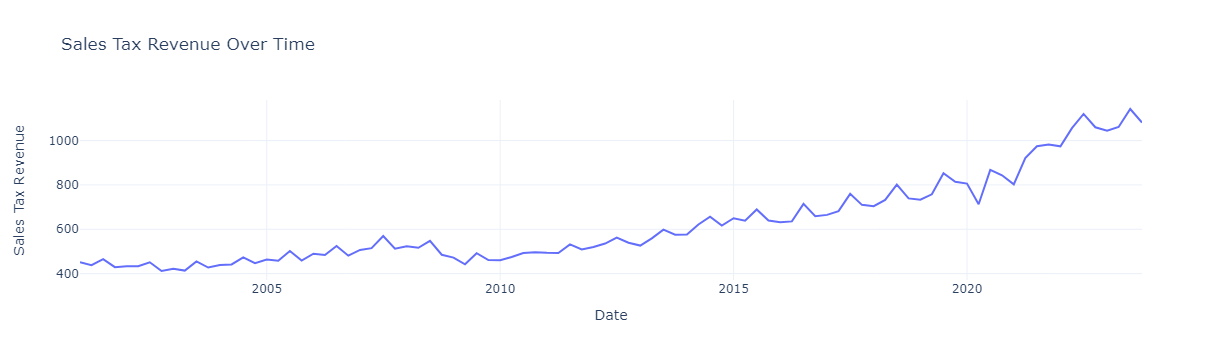

In [4]:
# Create a time series plot of sales tax revenue against date
fig = px.line(df, x='date', y='strev', title='Sales Tax Revenue Over Time',
              labels={'strev': 'Sales Tax Revenue', 'date': 'Date'},
              template='plotly_white')

# Show the plot
fig.show()

There seems to be a clear seasonal pattern. The following code uses a Seasonal Trend using LOESS decomposition to see the pattern more clearly.

### STL Additive

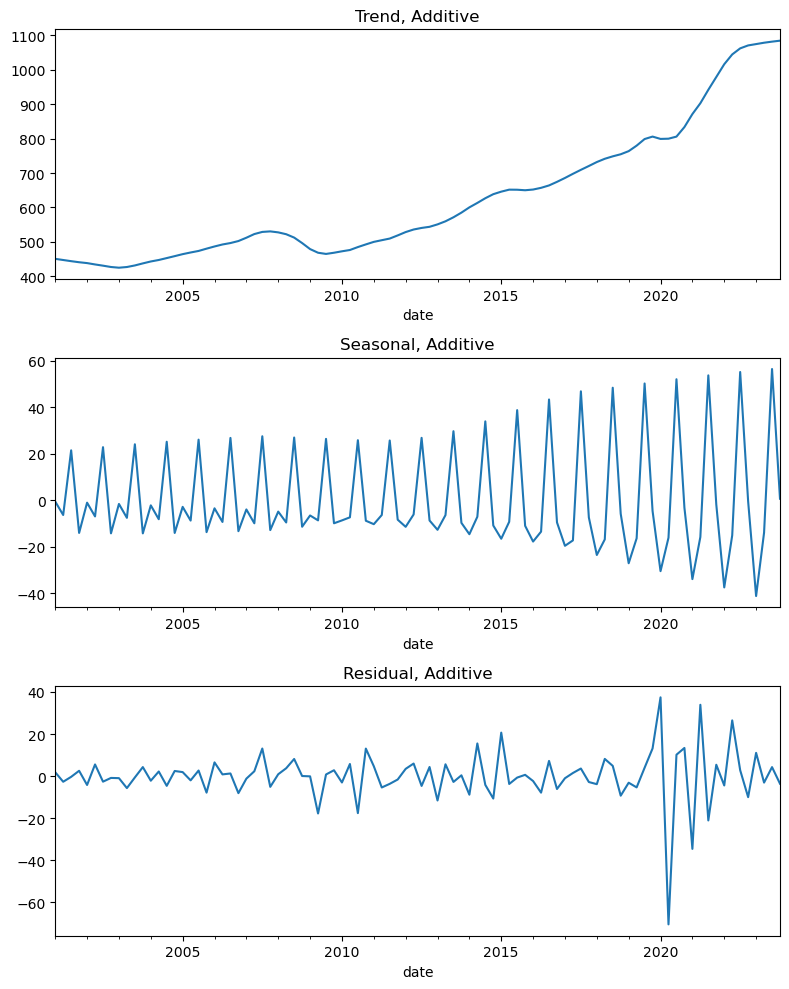

In [5]:
# Ensure the 'date' column is named correctly and set as the index
# Make sure the capitalization matches the column name in DataFrame
if 'date' in df.columns:  # Check for lowercase 'date'
    df.set_index('date', inplace=True)
elif 'Date' in df.columns:  # Check for uppercase 'Date'
    df.set_index('Date', inplace=True)
else:
    print("Date column not found in the DataFrame columns: ", df.columns)

# Apply the STL decomposition to the 'strev' series
# Ensure 'strev' data is non-missing and there's enough data points
stl = STL(df['strev'].dropna(), seasonal=13)
result = stl.fit()

# Plot the STL components
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
result.trend.plot(ax=axes[0], title='Trend, Additive')
result.seasonal.plot(ax=axes[1], title='Seasonal, Additive')
result.resid.plot(ax=axes[2], title='Residual, Additive')
fig.tight_layout()
plt.show()

The seasonal pattern increases over time, likely due to inflation / spurious growth.There are some clear large residuals around the pandemic where variance increases.

### Logarithmic Nominal Over Time

The following code plots the data on a logarithmic basis to see if there are multiplicative patterns.

            strev  log_strev
date                        
2001-01-01  451.9   6.113461
2001-04-01  438.2   6.082675
2001-07-01  465.0   6.142037
2001-10-01  429.2   6.061923
2002-01-01  433.0   6.070738


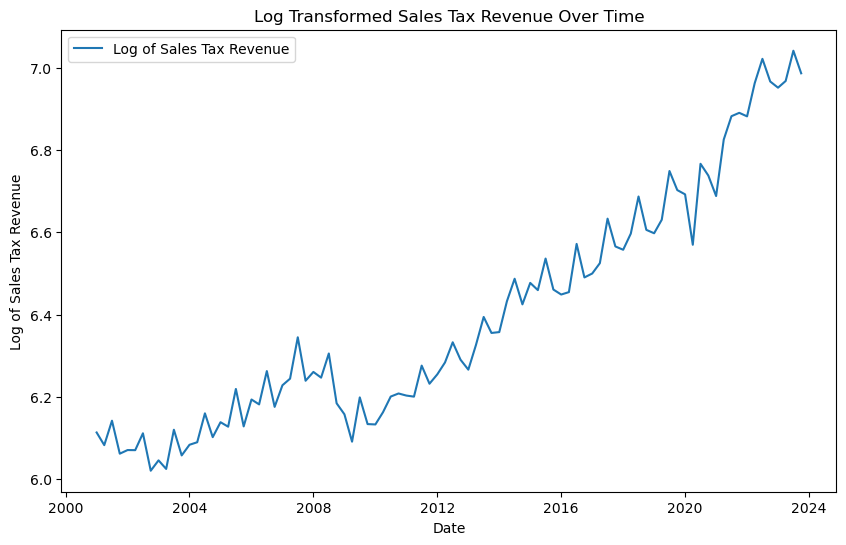

In [6]:
df['strev'] = df['strev'].replace(0, np.nan)

# Apply log transformation
df['log_strev'] = np.log(df['strev'])

# Check the first few rows to confirm the transformation
print(df[['strev', 'log_strev']].head())

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['log_strev'], label='Log of Sales Tax Revenue')
plt.title('Log Transformed Sales Tax Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Log of Sales Tax Revenue')
plt.legend()
plt.show()

# Logarithmic STL

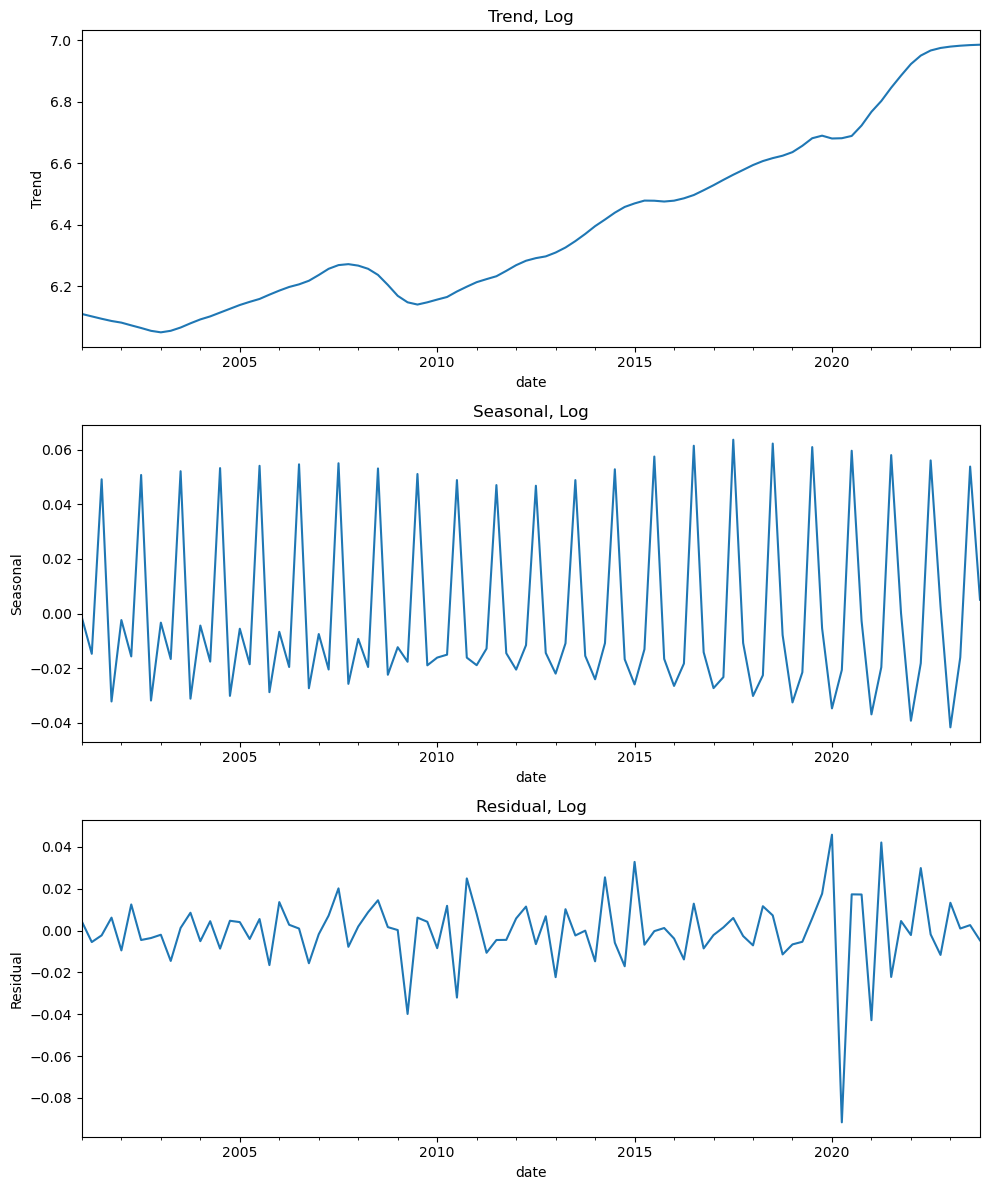

In [7]:
# Apply the STL decomposition to the 'log_strev' series
# Ensure non-missing data and at least a few cycles worth of data for meaningful decomposition
stl = STL(df['log_strev'].dropna(), seasonal=13)
result = stl.fit()

# Plot the STL components
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
result.trend.plot(ax=axes[0], title='Trend, Log')
result.seasonal.plot(ax=axes[1], title='Seasonal, Log')
result.resid.plot(ax=axes[2], title='Residual, Log')
axes[0].set_ylabel('Trend')
axes[1].set_ylabel('Seasonal')
axes[2].set_ylabel('Residual')
fig.tight_layout()
plt.show()

Relative to the nominal time series, the logarithmic seasonal pattern seems consistent. The residual variation appears more dramatic around the pandemic.

In [8]:
# Rename the 'personal income (COOTOT)' column to 'pi'
df.rename(columns={'COOTOT': 'pi'}, inplace=True)

In [9]:
print(df.head())

            strev        pi  log_strev
date                                  
2001-01-01  451.9  154657.2   6.113461
2001-04-01  438.2  154907.4   6.082675
2001-07-01  465.0  153611.9   6.142037
2001-10-01  429.2  153090.5   6.061923
2002-01-01  433.0  152796.5   6.070738


### Personal Income

Personal income likely has high correlation with sales tax revenue and will be the primary driver of the forecast.

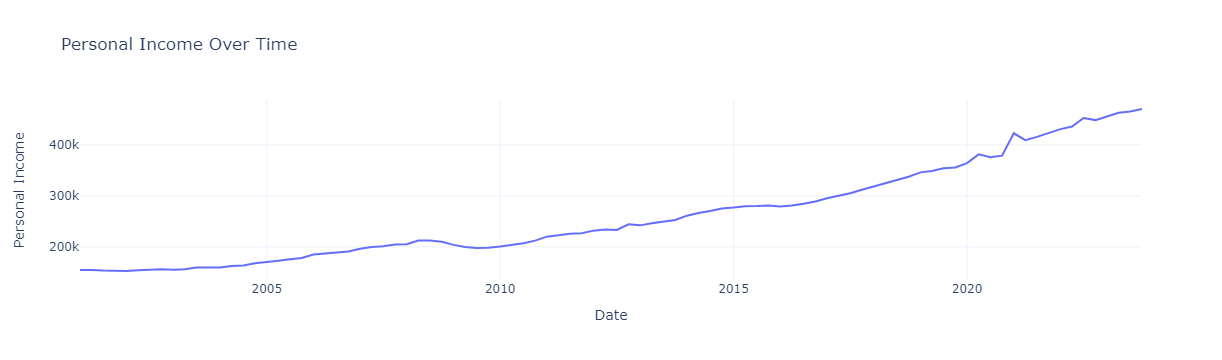

In [10]:
# Reset the index to make 'date' a regular column
df.reset_index(inplace=True)

# Create a time series plot of 'pi' against 'date'
fig = px.line(df, x='date', y='pi', title='Personal Income Over Time',
              labels={'pi': 'Personal Income', 'date': 'Date'},
              template='plotly_white')

# Show the plot
fig.show()

### Log Personal Income

This is the more relevant series as we are likely going to forecast on a log-log basis as the correlation between the two log variables is so high.

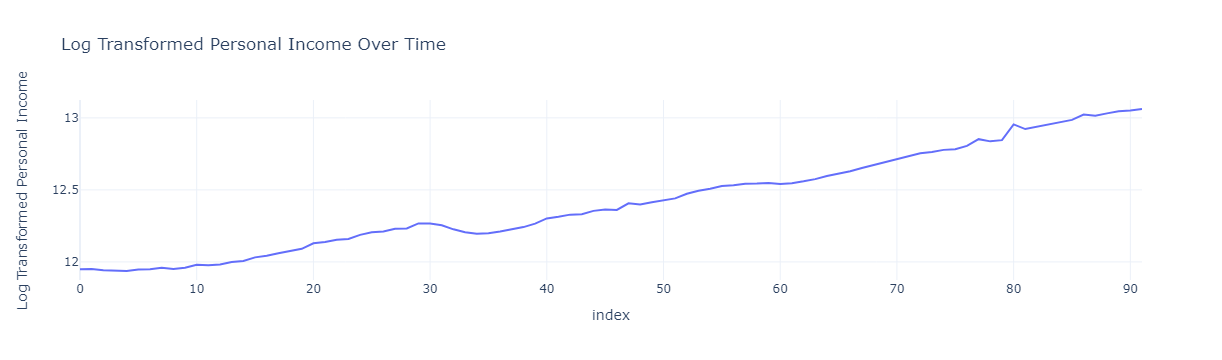

In [11]:
# Create a new variable for log-transformed personal income (log PI)
df['log_pi'] = np.log(df['pi'])

# Plot log PI against time
fig = px.line(df, x=df.index, y='log_pi', title='Log Transformed Personal Income Over Time',
              labels={'log_pi': 'Log Transformed Personal Income', 'date': 'Date'},
              template='plotly_white')

# Show the plot
fig.show()

The following code calculates the correlation between log-sales tax revenue and log-personal income.

In [12]:
correlation, p_value = stats.pearsonr(df['log_strev'], df['log_pi'])

# Printing the correlation and the p-value
print("Correlation between log_strev and log_pi:", correlation)
print("P-value of the correlation:", p_value)

# Calculating standard errors (for a Pearson correlation)
n = len(df['log_strev'])  # Number of data points
se = (1 - correlation**2) / (n - 2)**0.5  # Standard Error of the correlation coefficient

print("Standard Error of the correlation:", se)

Correlation between log_strev and log_pi: 0.970547272065089
P-value of the correlation: 2.0107711158190326e-57
Standard Error of the correlation: 0.006117741590505365


The correlation between the two variables is strong at 97%.

### Log Personal Income STL

This decomposition is to compare to the log sales tax revenue decomposition to see if there's a major divergence in patterns.

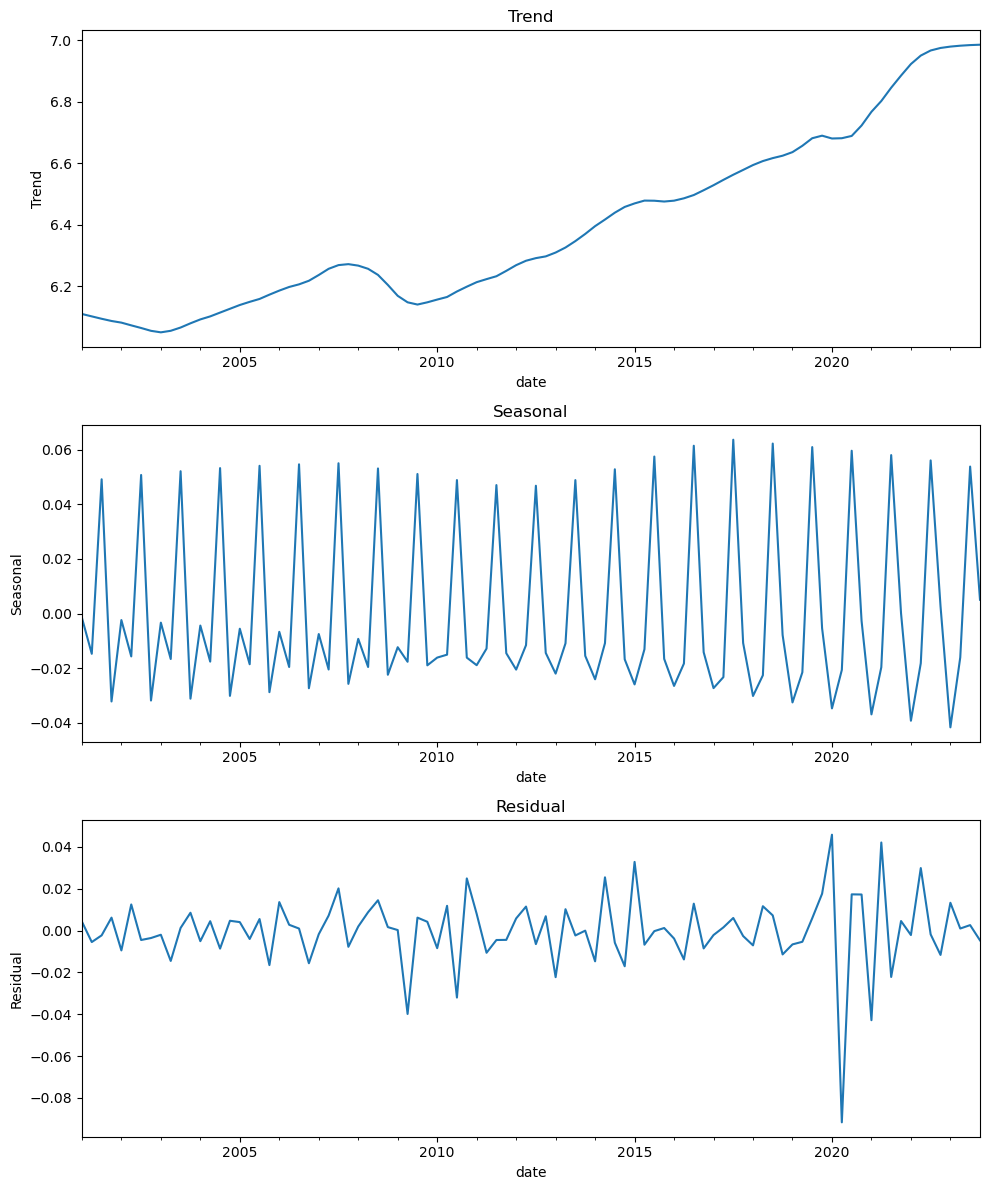

In [13]:
df.set_index('date', inplace=True)

stl_log_pi = STL(df['log_pi'].dropna(), seasonal=13)
result_log_pi = stl.fit()

# Plot the STL components
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
result_log_pi.trend.plot(ax=axes[0], title='Trend')
result_log_pi.seasonal.plot(ax=axes[1], title='Seasonal')
result_log_pi.resid.plot(ax=axes[2], title='Residual')
axes[0].set_ylabel('Trend')
axes[1].set_ylabel('Seasonal')
axes[2].set_ylabel('Residual')
fig.tight_layout()
plt.show()

There appears to be some divergence in the residuals around the pandemic. Additionally, the seasonality pattern becomes more dramatic in later years, likely due to variance from the pandemic.

### Additional Variable Load

The following code loads in some unemployment rate variables, also sourced from the St Louis Fed FRED database.

1. National unemployment rate: https://fred.stlouisfed.org/series/UNRATE
2. Colorado unemployment rate: https://fred.stlouisfed.org/series/COURN
3. National CPI: https://fred.stlouisfed.org/series/CPIAUCSL

In [14]:
# Load the UNRATE file into a dataframe
unrate_df = pd.read_csv("C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\Sales Tax Revenue Forecast\\UNRATE.csv")

# Rename the 'DATE' column to 'date'
unrate_df.rename(columns={'DATE': 'date'}, inplace=True)

# Calculate the 3-month moving average for the UNRATE column
unrate_df['3mma_ur'] = unrate_df['UNRATE'].rolling(window=3).mean()

# Rename the columns
unrate_df.rename(columns={'UNRATE': 'ur', '3M_MA_UNRATE': '3mma_ur'}, inplace=True)

# Display the head of the dataframe to verify the changes
print(unrate_df.head())

         date   ur   3mma_ur
0  1948-01-01  3.4       NaN
1  1948-02-01  3.8       NaN
2  1948-03-01  4.0  3.733333
3  1948-04-01  3.9  3.900000
4  1948-05-01  3.5  3.800000


In [15]:
# Load the UNRATE file into a dataframe
co_unrate_df = pd.read_csv("C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\Sales Tax Revenue Forecast\\COURN.csv")

# Rename the 'DATE' column to 'date'
co_unrate_df.rename(columns={'DATE': 'date'}, inplace=True)

# Calculate the 3-month moving average for the UNRATE column
co_unrate_df['co_3mma_ur'] = co_unrate_df['COURN'].rolling(window=3).mean()

# Rename the columns
co_unrate_df.rename(columns={'COURN': 'co_ur'}, inplace=True)

# Display the head of the dataframe to verify the changes
print(co_unrate_df.head())

         date  co_ur  co_3mma_ur
0  1976-01-01    7.1         NaN
1  1976-02-01    6.6         NaN
2  1976-03-01    6.9    6.866667
3  1976-04-01    5.2    6.233333
4  1976-05-01    4.5    5.533333


In [16]:
# Define the path to the CSV file
csv_file_path = r"C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\Sales Tax Revenue Forecast\\CPIAUCSL.csv"

# Load the CSV file into a DataFrame
cpiaucsl_df = pd.read_csv(csv_file_path)

# Print the first few rows to confirm it's loaded correctly
print(cpiaucsl_df.head())

         DATE  CPIAUCSL
0  1947-01-01     21.48
1  1947-02-01     21.62
2  1947-03-01     22.00
3  1947-04-01     22.00
4  1947-05-01     21.95


In [17]:
# Rename columns in the cpiaucsl_df DataFrame
cpiaucsl_df.rename(columns={'DATE': 'date', 'CPIAUCSL': 'cpi'}, inplace=True)

# Convert 'date' column to datetime and set as the index in cpiaucsl_df
cpiaucsl_df['date'] = pd.to_datetime(cpiaucsl_df['date'])
cpiaucsl_df.set_index('date', inplace=True)

# Ensure the 'date' column in the main DataFrame and is also of type datetime and set as the index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
elif not isinstance(df.index, pd.DatetimeIndex):
    # If 'date' is not a column and the index is not a DatetimeIndex, raise an error
    raise ValueError("DataFrame index is not set to datetime.")

# Concatenate the 'cpi' column to the df DataFrame based on matching 'date' indices
df = df.join(cpiaucsl_df['cpi'])

# Verify the combined DataFrame
print(df.head())

            strev        pi  log_strev     log_pi    cpi
date                                                    
2001-01-01  451.9  154657.2   6.113461  11.948966  175.6
2001-04-01  438.2  154907.4   6.082675  11.950583  176.4
2001-07-01  465.0  153611.9   6.142037  11.942185  177.4
2001-10-01  429.2  153090.5   6.061923  11.938785  177.6
2002-01-01  433.0  152796.5   6.070738  11.936862  177.7


In [18]:
# Reset index to convert the index 'date' back to a column
df.reset_index(inplace=True)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert 'date' column to datetime in unrate_df
unrate_df['date'] = pd.to_datetime(unrate_df['date'])

# Convert 'date' column to datetime in co_unrate_df
co_unrate_df['date'] = pd.to_datetime(co_unrate_df['date'])

In [19]:
# Check if 'date' column exists in the DataFrame
if 'date' in df.columns:
    # Convert the 'date' column to datetime64[ns] if it's not already
    df['date'] = pd.to_datetime(df['date'])

    # Merge the 3mma_ur from unrate_df with the main dataframe 'df' based on the 'date' column
    df = pd.merge(df, unrate_df[['date', '3mma_ur']], how='left', on='date')

    # Merge the co_3mma_ur from co_unrate_df with the main dataframe 'df' based on the 'date' column
    df = pd.merge(df, co_unrate_df[['date', 'co_3mma_ur']], how='left', on='date')
else:
    print("The 'date' column does not exist in the DataFrame.")

print(df.head())

        date  strev        pi  log_strev     log_pi    cpi   3mma_ur  \
0 2001-01-01  451.9  154657.2   6.113461  11.948966  175.6  4.000000   
1 2001-04-01  438.2  154907.4   6.082675  11.950583  176.4  4.300000   
2 2001-07-01  465.0  153611.9   6.142037  11.942185  177.4  4.466667   
3 2001-10-01  429.2  153090.5   6.061923  11.938785  177.6  5.066667   
4 2002-01-01  433.0  152796.5   6.070738  11.936862  177.7  5.633333   

   co_3mma_ur  
0    2.700000  
1    3.133333  
2    3.433333  
3    4.100000  
4    5.666667  


In [20]:
# Add a column for the log of 3mma_ur
df['log_3mma_ur'] = np.log(df['3mma_ur'])

# Add a column for the log of co_3mma_ur
df['log_co_3mma_ur'] = np.log(df['co_3mma_ur'])

# Display the updated DataFrame
print(df.head())

        date  strev        pi  log_strev     log_pi    cpi   3mma_ur  \
0 2001-01-01  451.9  154657.2   6.113461  11.948966  175.6  4.000000   
1 2001-04-01  438.2  154907.4   6.082675  11.950583  176.4  4.300000   
2 2001-07-01  465.0  153611.9   6.142037  11.942185  177.4  4.466667   
3 2001-10-01  429.2  153090.5   6.061923  11.938785  177.6  5.066667   
4 2002-01-01  433.0  152796.5   6.070738  11.936862  177.7  5.633333   

   co_3mma_ur  log_3mma_ur  log_co_3mma_ur  
0    2.700000     1.386294        0.993252  
1    3.133333     1.458615        1.142097  
2    3.433333     1.496642        1.233532  
3    4.100000     1.622683        1.410987  
4    5.666667     1.728701        1.734601  


### Seasonality Visualization and Forecasting Variable Prep

The following code visualizes the seasonally adjusted trend and creates additional variable used in some of the forecasts.

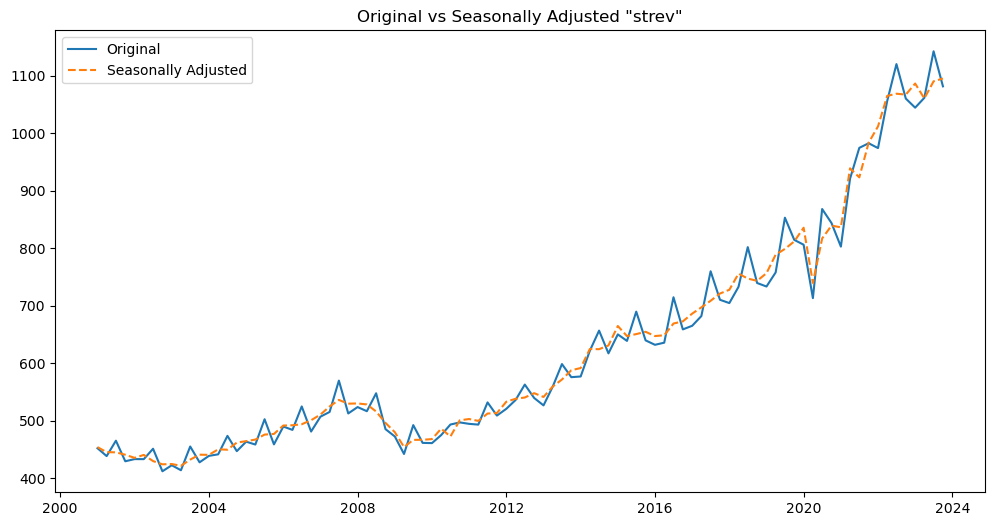

            strev        pi  log_strev     log_pi    cpi   3mma_ur  \
date                                                                 
2001-01-01  451.9  154657.2   6.113461  11.948966  175.6  4.000000   
2001-04-01  438.2  154907.4   6.082675  11.950583  176.4  4.300000   
2001-07-01  465.0  153611.9   6.142037  11.942185  177.4  4.466667   
2001-10-01  429.2  153090.5   6.061923  11.938785  177.6  5.066667   
2002-01-01  433.0  152796.5   6.070738  11.936862  177.7  5.633333   

            co_3mma_ur  log_3mma_ur  log_co_3mma_ur  strev_seasonally_adjusted  
date                                                                            
2001-01-01    2.700000     1.386294        0.993252                 453.778783  
2001-04-01    3.133333     1.458615        1.142097                 445.094876  
2001-07-01    3.433333     1.496642        1.233532                 444.771078  
2001-10-01    4.100000     1.622683        1.410987                 440.544304  
2002-01-01    5.666667 

In [21]:
# Ensure 'date' is in datetime format and set it as the index only
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Perform seasonal decomposition using STL with a seasonal period of 4 (for quarterly data)
stl = STL(df['strev'], period=4, seasonal=7)
result = stl.fit()

# Extract the seasonal component
seasonal_component = result.seasonal

# Create the seasonally adjusted series
df['strev_seasonally_adjusted'] = df['strev'] - seasonal_component

# Plot the original and seasonally adjusted series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['strev'], label='Original')
plt.plot(df.index, df['strev_seasonally_adjusted'], label='Seasonally Adjusted', linestyle='--')
plt.title('Original vs Seasonally Adjusted "strev"')
plt.legend()
plt.show()

# Print the head of the DataFrame to verify structure
print(df.head())

The seasonally adjusted sales tax revenues have been recreated. The following code produces additional dummy variables for lags and recessionary periods that are introducing variance into the pattern: the pandemic and great financial crisis.

There is much room for experimentation on which of these dummy variables lead to the best fit.

In [22]:
# Generate lagged variables for lag 1 and lag 4
for col in df.columns:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag4'] = df[col].shift(4)

In [23]:
# Initialize the 'pand' column to 0 for all rows
df['pand'] = 0

# Define the pandemic quarters
pandemic_quarters = pd.to_datetime(['2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01'])

# Set the 'pand' column to 1 for the pandemic quarters
df.loc[df.index.isin(pandemic_quarters), 'pand'] = 1

# Check the result
print(df[['pand']].tail(16))

            pand
date            
2020-01-01     0
2020-04-01     1
2020-07-01     1
2020-10-01     1
2021-01-01     1
2021-04-01     0
2021-07-01     0
2021-10-01     0
2022-01-01     0
2022-04-01     0
2022-07-01     0
2022-10-01     0
2023-01-01     0
2023-04-01     0
2023-07-01     0
2023-10-01     0


In [24]:
# Initialize the 'gfc' column to 0 for all rows
df['gfc'] = 0

# Define the Great Financial Crisis quarters
gfc_quarters = pd.to_datetime(['2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01', '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01', '2010-01-01'])

# Set the 'gfc' column to 1 for the pandemic quarters
df.loc[df.index.isin(gfc_quarters), 'gfc'] = 1

# Check the result
print(df[['gfc']].head(40))

            gfc
date           
2001-01-01    0
2001-04-01    0
2001-07-01    0
2001-10-01    0
2002-01-01    0
2002-04-01    0
2002-07-01    0
2002-10-01    0
2003-01-01    0
2003-04-01    0
2003-07-01    0
2003-10-01    0
2004-01-01    0
2004-04-01    0
2004-07-01    0
2004-10-01    0
2005-01-01    0
2005-04-01    0
2005-07-01    0
2005-10-01    0
2006-01-01    0
2006-04-01    0
2006-07-01    0
2006-10-01    0
2007-01-01    0
2007-04-01    0
2007-07-01    0
2007-10-01    0
2008-01-01    1
2008-04-01    1
2008-07-01    1
2008-10-01    1
2009-01-01    1
2009-04-01    1
2009-07-01    1
2009-10-01    1
2010-01-01    1
2010-04-01    0
2010-07-01    0
2010-10-01    0


The following code creates cutoffs for training and validation periods.

In [25]:
# Calculate the number of data points
total_points = len(df)

# Calculate cutoff points for 75% and 80%
cutoff_index_75 = int(total_points * 0.75)
cutoff_index_80 = int(total_points * 0.80)

# Get the dates corresponding to these indices
cutoff_date_75 = df.index[cutoff_index_75]
cutoff_date_80 = df.index[cutoff_index_80]

cutoff_date_75, cutoff_date_80

(Timestamp('2018-04-01 00:00:00'), Timestamp('2019-04-01 00:00:00'))

# Model 1: Basic SARIMA with Recession Dummies

The following code produces and evaluates the fit of a Seasonal Autoregressive Integrated Moving Average (SARIMA) model.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                     
Dep. Variable:                         log_strev   No. Observations:                   88
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                 166.426
Date:                           Mon, 08 Jul 2024   AIC                           -316.852
Time:                                   12:48:24   BIC                           -297.502
Sample:                               01-01-2002   HQIC                          -309.078
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7076      0.569     -3.000      0.003      -2.823      -0.592
log_pi             0.2238      

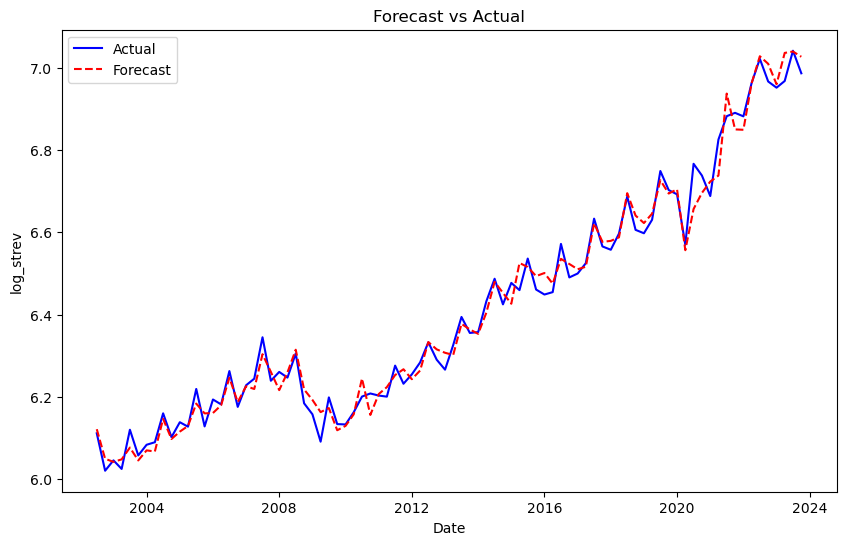

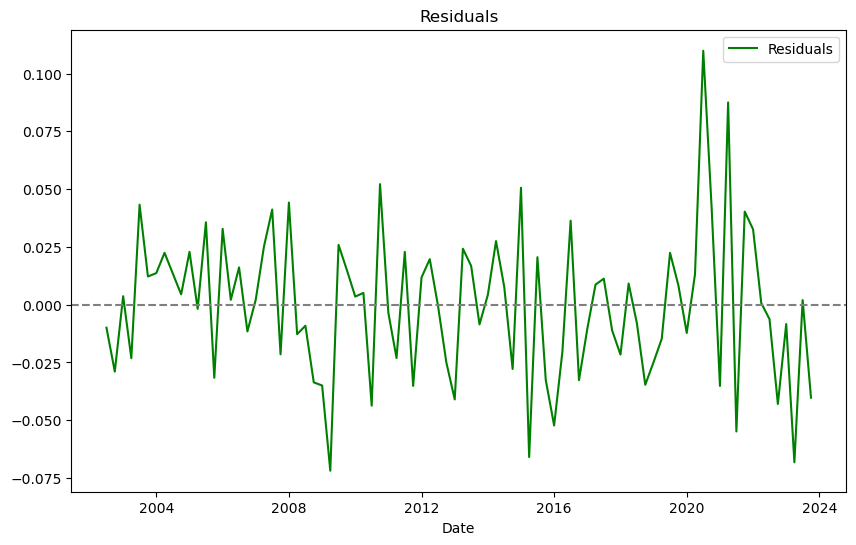

<Figure size 1000x600 with 0 Axes>

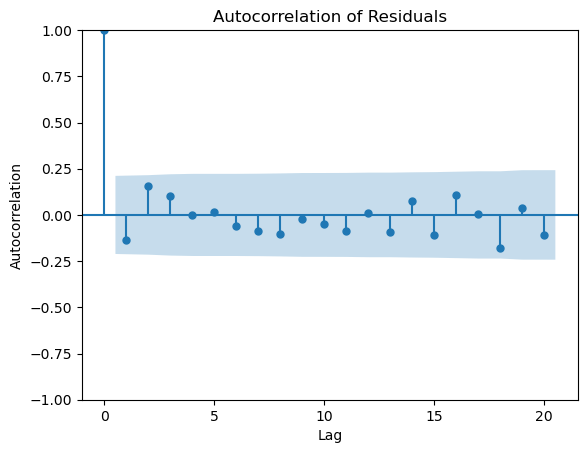

In [26]:
# Drop rows with NaN values in the specified columns, including the 'pand' and 'gfc' variables
cleaned_df = df.dropna(subset=['log_strev', 'log_pi', 'log_strev_lag4', 'pand', 'gfc'])

# Define the dependent variable
endog = cleaned_df['log_strev']

# Define the exogenous regressors, include constant for intercept, and add 'pand' and 'gfc' to the exogenous variables
exog = cleaned_df[['log_pi', 'log_strev_lag4', 'pand', 'gfc']]
exog = sm.add_constant(exog)  # adds a constant term to the regressors

# Specify the SARIMAX Model
# Note: (p,d,q) are non-seasonal orders, (P,D,Q,s) are seasonal orders
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1,0,0), seasonal_order=(1,0,0,4), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

# Compute predictions
predictions = results.get_prediction(start=cleaned_df.index[0], end=cleaned_df.index[-1])
predictions_mean = predictions.predicted_mean

# Actual values
actuals = cleaned_df['log_strev']

# To ignore the first two values, adjust the start of the plot. This accounts for the lag input of some variables.
ignore_first = 2
start_plot_index = actuals.index[ignore_first]

# Compute residuals
residuals = actuals - predictions_mean

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals[ignore_first:]))
mape = np.mean(np.abs(residuals[ignore_first:]) / np.abs(actuals[ignore_first:])) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

# Plot forecast versus actual, ignoring the first two forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actuals.index[ignore_first:], actuals[ignore_first:], label='Actual', color='blue')
plt.plot(predictions_mean.index[ignore_first:], predictions_mean[ignore_first:], label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Plot residuals, ignoring the first two values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index[ignore_first:], residuals[ignore_first:], label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')  # Add horizontal line at y=0 for reference
plt.title('Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Plot ACF of residuals, ignoring the first two observations
plt.figure(figsize=(10, 6))
plot_acf(residuals[2:], lags=20, alpha=0.05)  # Start from the third element of residuals
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Model 2: SARIMA with (1,1,0)

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                     
Dep. Variable:                         log_strev   No. Observations:                   88
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 162.589
Date:                           Mon, 08 Jul 2024   AIC                           -309.178
Time:                                   12:48:26   BIC                           -289.924
Sample:                               01-01-2002   HQIC                          -301.448
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.252e-09        nan        nan        nan         nan         nan
log_pi             0.1477      

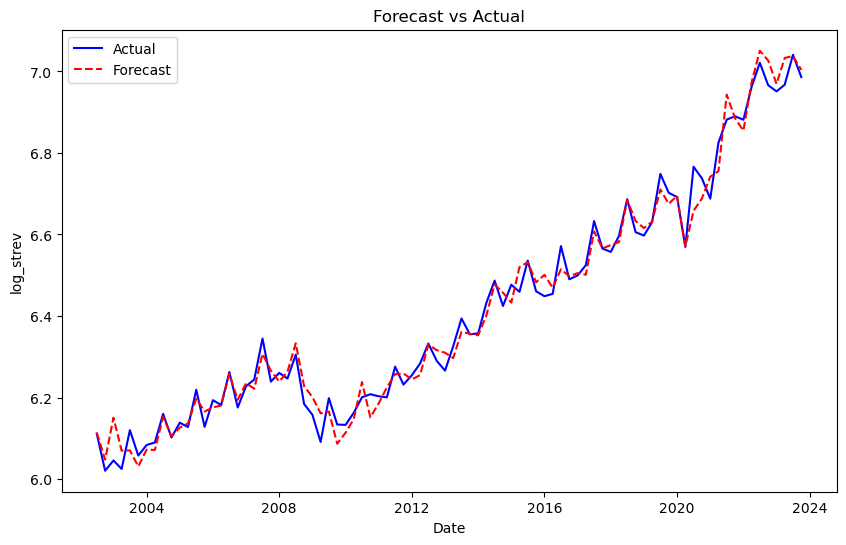

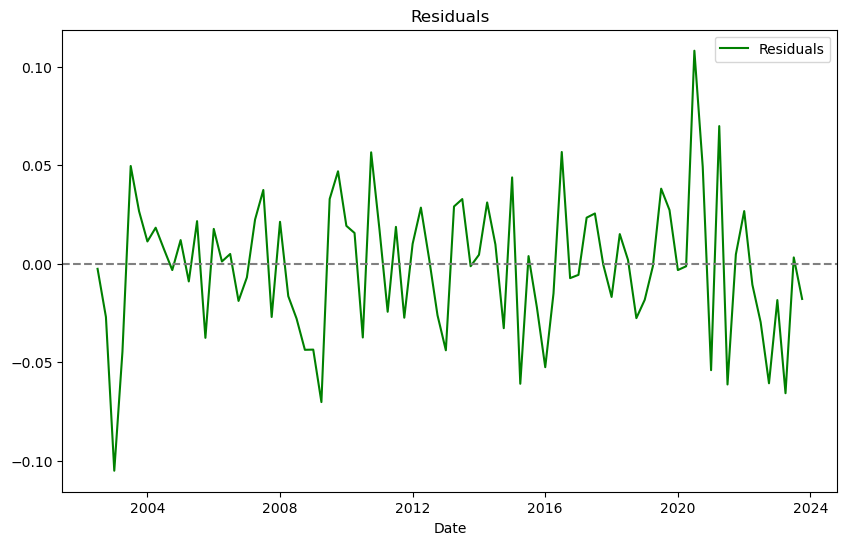

<Figure size 1000x600 with 0 Axes>

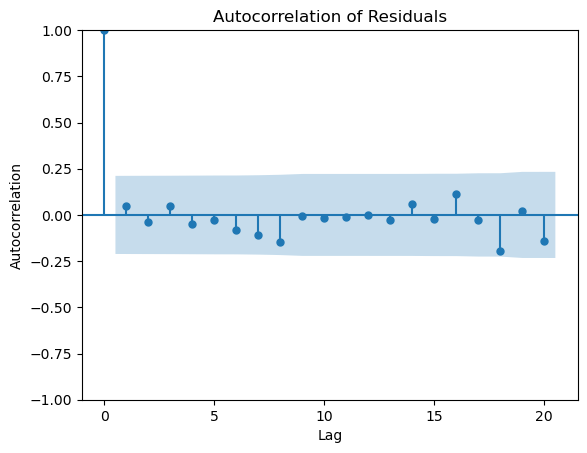

In [27]:
# Drop rows with NaN values in the specified columns, including the 'pand' and 'gfc' variables
cleaned_df = df.dropna(subset=['log_strev', 'log_pi', 'log_strev_lag4', 'pand', 'gfc'])

# Define the dependent variable
endog = cleaned_df['log_strev']

# Define the exogenous regressors, include constant for intercept, and add 'pand' and 'gfc' to the exogenous variables
exog = cleaned_df[['log_pi', 'log_strev_lag4', 'pand', 'gfc']]
exog = sm.add_constant(exog)  # adds a constant term to the regressors

# Specify the SARIMAX Model
# Note: (p,d,q) are non-seasonal orders, (P,D,Q,s) are seasonal orders
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1,1,0), seasonal_order=(1,0,0,4), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

# Compute predictions
predictions = results.get_prediction(start=cleaned_df.index[0], end=cleaned_df.index[-1])
predictions_mean = predictions.predicted_mean

# Actual values
actuals = cleaned_df['log_strev']  # or adjust if the actual values are in a different form

# To ignore the first two values, adjust the start of the plot
ignore_first = 2
start_plot_index = actuals.index[ignore_first]

# Compute residuals
residuals = actuals - predictions_mean

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals[ignore_first:]))
mape = np.mean(np.abs(residuals[ignore_first:]) / np.abs(actuals[ignore_first:])) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

# Plot forecast versus actual, ignoring the first two forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actuals.index[ignore_first:], actuals[ignore_first:], label='Actual', color='blue')
plt.plot(predictions_mean.index[ignore_first:], predictions_mean[ignore_first:], label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Plot residuals, ignoring the first two values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index[ignore_first:], residuals[ignore_first:], label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')  # Add horizontal line at y=0 for reference
plt.title('Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Plot ACF of residuals, ignoring the first two observations
plt.figure(figsize=(10, 6))
plot_acf(residuals[2:], lags=20, alpha=0.05)  # Start from the third element of residuals
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Model 3: Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-300.666, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-229.160, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-291.700, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-276.252, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-228.794, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=-270.528, Time=0.47 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=-290.501, Time=0.50 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=-296.230, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=-296.959, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=-255.579, Time=0.43 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=-275.080, Time=0.60 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=-294.200, Time=0.71 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=-302.429, Time=1.08 sec
 ARIMA(1,1,2)(2,0,2)[4] intercept   : AIC=-300.839, Time=0.80 sec
 ARIMA(2,1,1)(2,0,2)[4] intercept

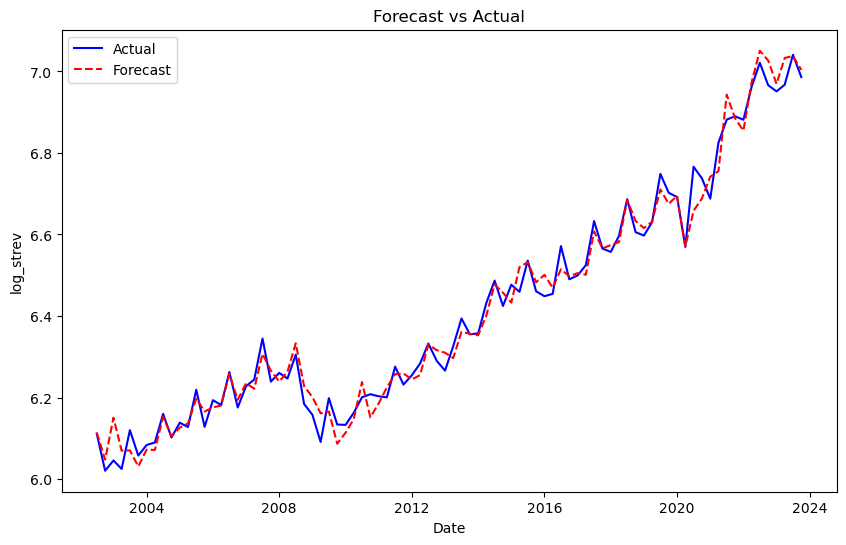

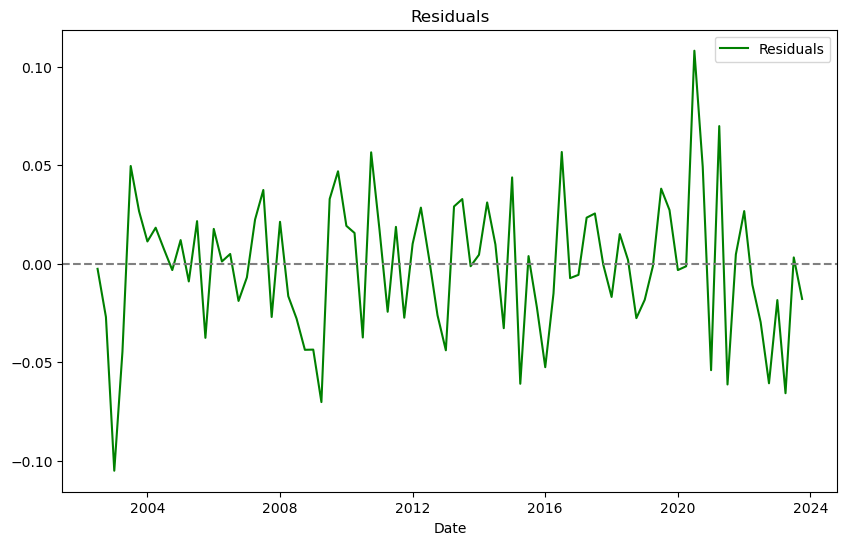

<Figure size 1000x600 with 0 Axes>

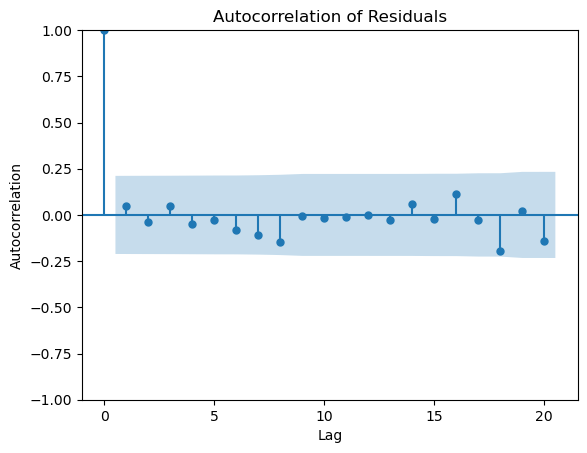

In [28]:
# Define the dependent variable
endog = cleaned_df['log_strev']

# Define the exogenous regressors, if you have any
exog = cleaned_df[['log_pi', 'log_strev_lag4', 'pand', 'gfc']]

# Use auto_arima to find the best ARIMA model parameters
model = pm.auto_arima(endog, exogenous=exog, seasonal=True, m=4, 
                      stepwise=True, trace=True, error_action='ignore', 
                      suppress_warnings=True)

# Print the summary of the selected ARIMA model
print(model.summary())

# Produce predictions
predictions = model.predict(n_periods=5, exogenous=exog.tail(5))

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals[ignore_first:]))
mape = np.mean(np.abs(residuals[ignore_first:]) / np.abs(actuals[ignore_first:])) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

# Plot forecast versus actual, ignoring the first two forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actuals.index[ignore_first:], actuals[ignore_first:], label='Actual', color='blue')
plt.plot(predictions_mean.index[ignore_first:], predictions_mean[ignore_first:], label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Plot residuals, ignoring the first two values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index[ignore_first:], residuals[ignore_first:], label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')  # Add horizontal line at y=0 for reference
plt.title('Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Plot ACF of residuals, ignoring the first two observations
plt.figure(figsize=(10, 6))
plot_acf(residuals[2:], lags=20, alpha=0.05)  # Start from the third element of residuals
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

**Evaluation:**
I prefer the ARIMA (1,1,0) model due to it's more even distribution of residual autocorrelation despite it having a slightly higher MAPE than AUTO ARIMA. The higher MAPE is equivalent to 3 basis points. Now I want to test a decaying intervention effect from the pandemic and GFC.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                     
Dep. Variable:                         log_strev   No. Observations:                   88
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 162.589
Date:                           Mon, 08 Jul 2024   AIC                           -309.178
Time:                                   12:48:57   BIC                           -289.924
Sample:                               01-01-2002   HQIC                          -301.448
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.252e-09        nan        nan        nan         nan         nan
log_pi             0.1477      

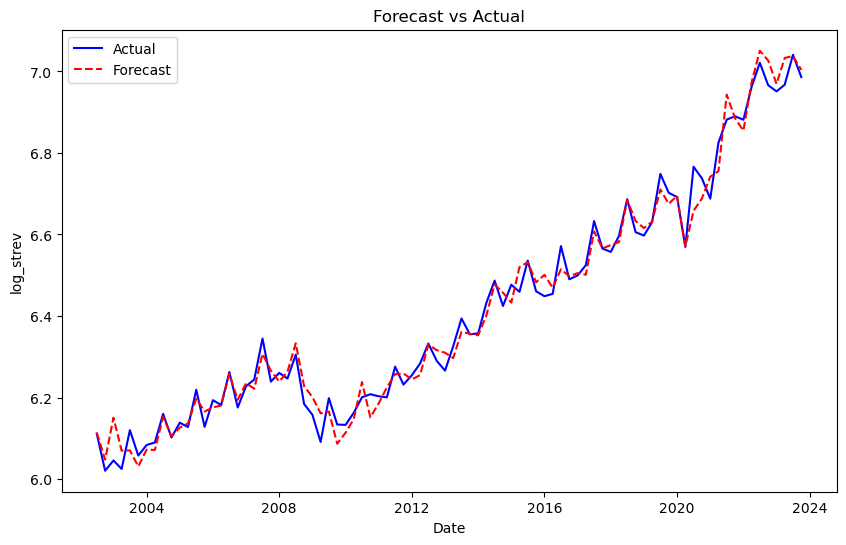

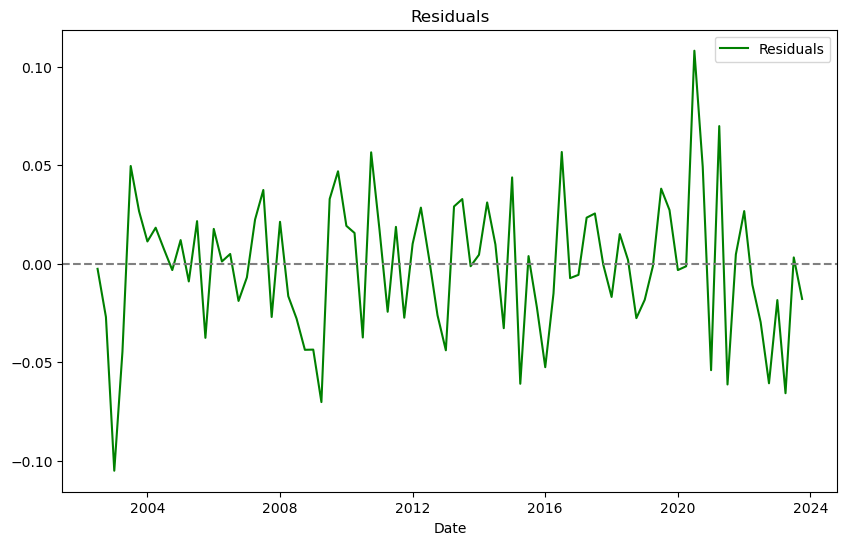

<Figure size 1000x600 with 0 Axes>

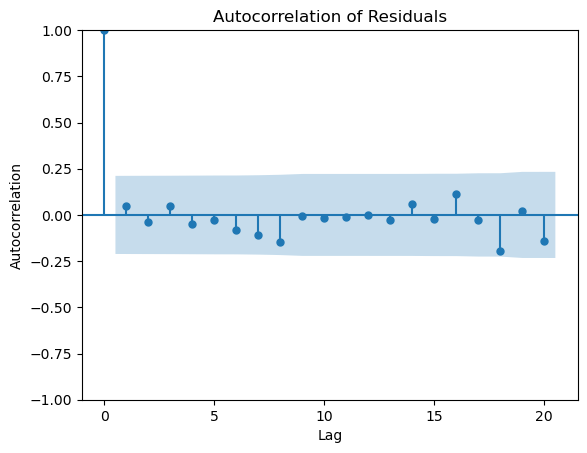

In [29]:
# Drop rows with NaN values in the specified columns, including the 'pand' and 'gfc' variables
cleaned_df = df.dropna(subset=['log_strev', 'log_pi', 'log_strev_lag4', 'pand', 'gfc'])

# Define the dependent variable
endog = cleaned_df['log_strev']

# Define the exogenous regressors, include constant for intercept, and add 'pand' and 'gfc' to the exogenous variables
exog = cleaned_df[['log_pi', 'log_strev_lag4', 'pand', 'gfc']]
exog = sm.add_constant(exog)  # adds a constant term to the regressors

# Specify the SARIMAX Model
# Note: (p,d,q) are non-seasonal orders, (P,D,Q,s) are seasonal orders
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1,1,0), seasonal_order=(1,0,0,4), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

# Compute predictions
predictions = results.get_prediction(start=cleaned_df.index[0], end=cleaned_df.index[-1])
predictions_mean = predictions.predicted_mean

# Actual values
actuals = cleaned_df['log_strev']  # or adjust if the actual values are in a different form

# To ignore the first two values, adjust the start of the plot
ignore_first = 2
start_plot_index = actuals.index[ignore_first]

# Compute residuals
residuals = actuals - predictions_mean

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals[ignore_first:]))
mape = np.mean(np.abs(residuals[ignore_first:]) / np.abs(actuals[ignore_first:])) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

# Plot forecast versus actual, ignoring the first two forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actuals.index[ignore_first:], actuals[ignore_first:], label='Actual', color='blue')
plt.plot(predictions_mean.index[ignore_first:], predictions_mean[ignore_first:], label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Plot residuals, ignoring the first two values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index[ignore_first:], residuals[ignore_first:], label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')  # Add horizontal line at y=0 for reference
plt.title('Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Plot ACF of residuals, ignoring the first two observations
plt.figure(figsize=(10, 6))
plot_acf(residuals[2:], lags=20, alpha=0.05)  # Start from the third element of residuals
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The following code produces decay variables for the impact of the recessions. There is much room for experimentation in the length of these recessionary policy variables. After a few attempts at better fits, these are my current specifications. They are designed to show the impact of each recession 'wearing off' in an exponential decay function.

In [30]:
# Create decay variables

if not isinstance(df.index, pd.DatetimeIndex):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Initialize the variables to 0
df['pand_start'] = 0
df['gfc_start'] = 0

# Set to 1 in the specified start quarters
df.loc['2020-04-01', 'pand_start'] = 1
df.loc['2008-07-01', 'gfc_start'] = 1

In [31]:
# Define the number of periods over which the impact decays
pand_periods = 5  # quarters for pandemic
gfc_periods = 16  # quarters for financial crisis

# Calculate the decay factors
pand_decay_factor = np.exp(-np.log(0.05) / pand_periods)
gfc_decay_factor = np.exp(-np.log(0.05) / gfc_periods)

In [32]:
def apply_exponential_decay(df, start_column, decay_factor, decay_column_name):
    df[decay_column_name] = 0.0  
    for i in range(len(df)):
        if df.loc[df.index[i], start_column] == 1:
            df.loc[df.index[i], decay_column_name] = 1  # Set to 1 at the start of the event
        elif i > 0 and df.loc[df.index[i - 1], decay_column_name] > 0:
            # Apply the decay to the previous value until it becomes very small
            previous_value = df.loc[df.index[i - 1], decay_column_name]
            new_value = previous_value * decay_factor
            df.loc[df.index[i], decay_column_name] = new_value if new_value > 0.01 else 0  # Maintaining decay until negligible

    return df

# Applying the corrected decay with more accurate factors
df = apply_exponential_decay(df, 'pand_start', np.exp(np.log(0.05) / 5), 'pand_decay')
df = apply_exponential_decay(df, 'gfc_start', np.exp(np.log(0.05) / 16), 'gfc_decay')

# Print the contents to verify
print(df[['pand_start', 'pand_decay', 'gfc_start', 'gfc_decay']].tail(20))
print(df[['pand_start', 'pand_decay', 'gfc_start', 'gfc_decay']].head(40))

            pand_start  pand_decay  gfc_start  gfc_decay
date                                                    
2019-01-01           0    0.000000          0        0.0
2019-04-01           0    0.000000          0        0.0
2019-07-01           0    0.000000          0        0.0
2019-10-01           0    0.000000          0        0.0
2020-01-01           0    0.000000          0        0.0
2020-04-01           1    1.000000          0        0.0
2020-07-01           0    0.549280          0        0.0
2020-10-01           0    0.301709          0        0.0
2021-01-01           0    0.165723          0        0.0
2021-04-01           0    0.091028          0        0.0
2021-07-01           0    0.050000          0        0.0
2021-10-01           0    0.027464          0        0.0
2022-01-01           0    0.015085          0        0.0
2022-04-01           0    0.000000          0        0.0
2022-07-01           0    0.000000          0        0.0
2022-10-01           0    0.000

# *Preferred Model*: (1,0,0)(0,0,0,4) ARIMA with Decaying GFC Variable

This is ultimately the preferred model of the many versions tried over the course of the project. There is additional code here to evaluate ARCH and GARCH effects in variance. There is also evaluation of a validation period based on the most recent forecasts LCS provided for comparison.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:              log_strev   No. Observations:                   88
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 174.570
Date:                Mon, 08 Jul 2024   AIC                           -333.140
Time:                        12:48:59   BIC                           -313.413
Sample:                    01-01-2002   HQIC                          -325.197
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7630      0.416     -4.235      0.000      -2.579      -0.947
log_pi             0.2543      0.063      4.043      0.000       0.131       0.378
log_strev_lag4     0.7887      0.071

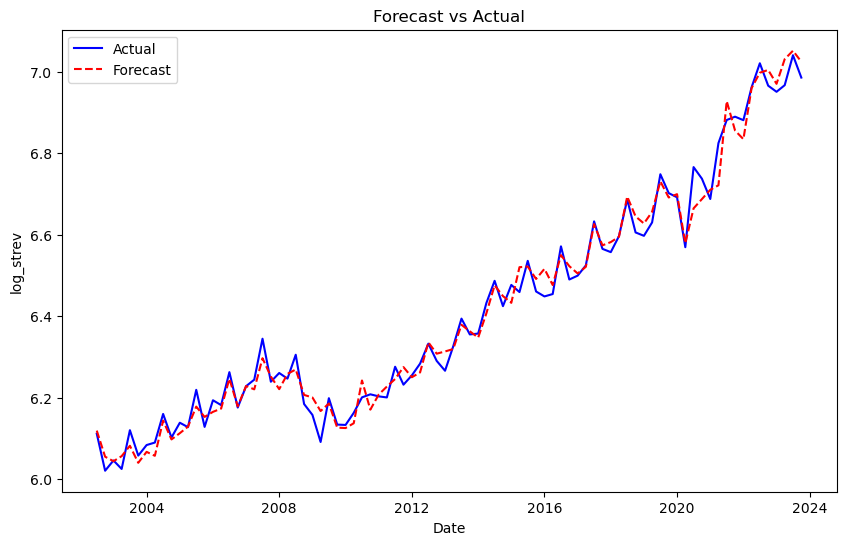

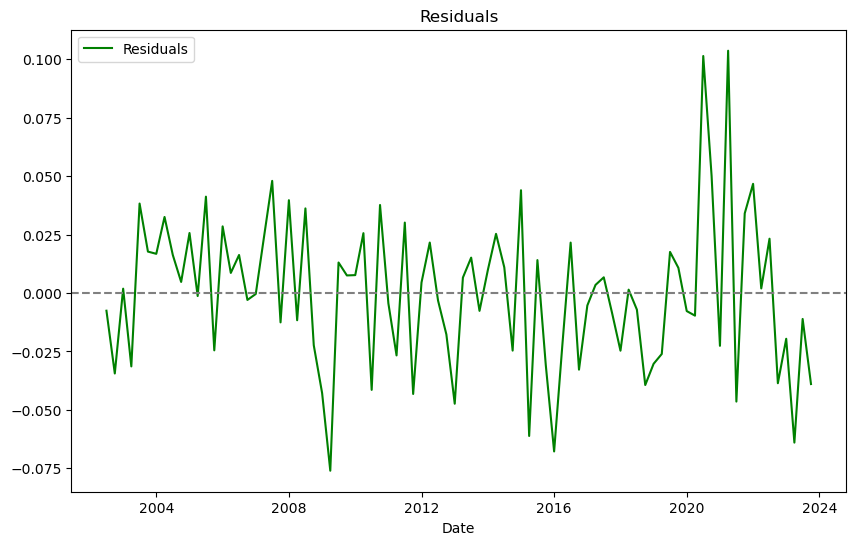

<Figure size 1000x600 with 0 Axes>

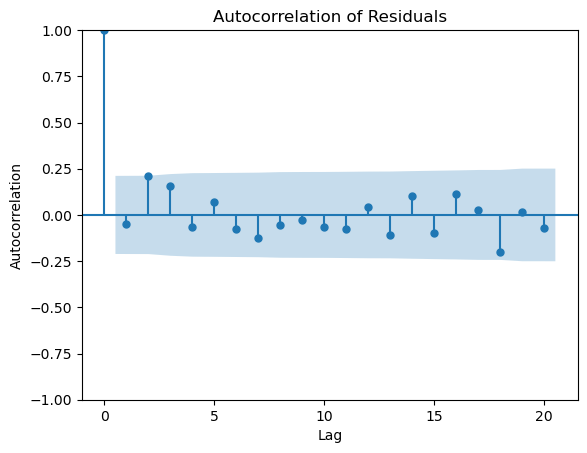

C:\Users\tejer\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.011
Vol Model:                      GARCH   Log-Likelihood:                179.417
Distribution:                  Normal   AIC:                          -352.834
Method:            Maximum Likelihood   BIC:                          -345.402
                                        No. Observations:                   88
Date:                Mon, Jul 08 2024   Df Residuals:                       88
Time:                        12:49:00   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.6470e-06  7.578e-10  1.273e+04      0.000 [9.

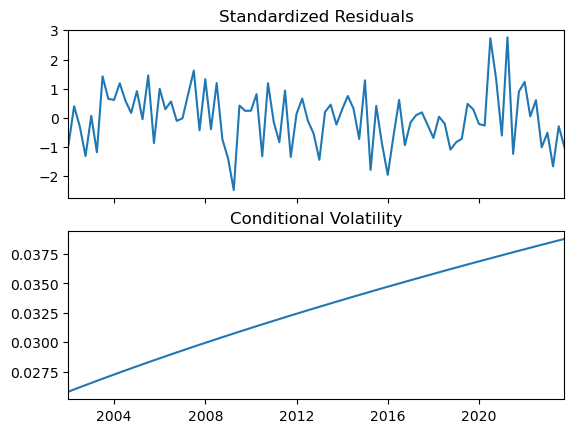

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



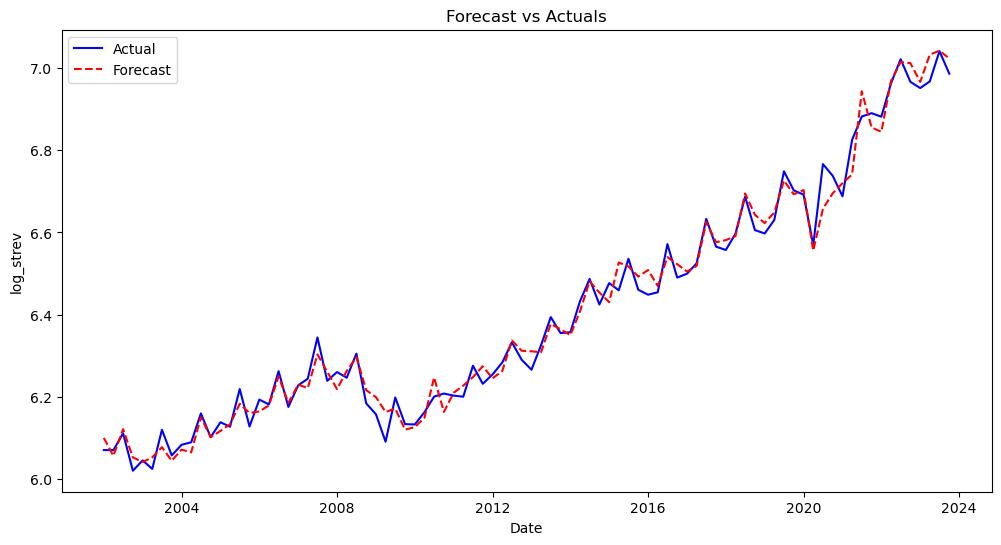

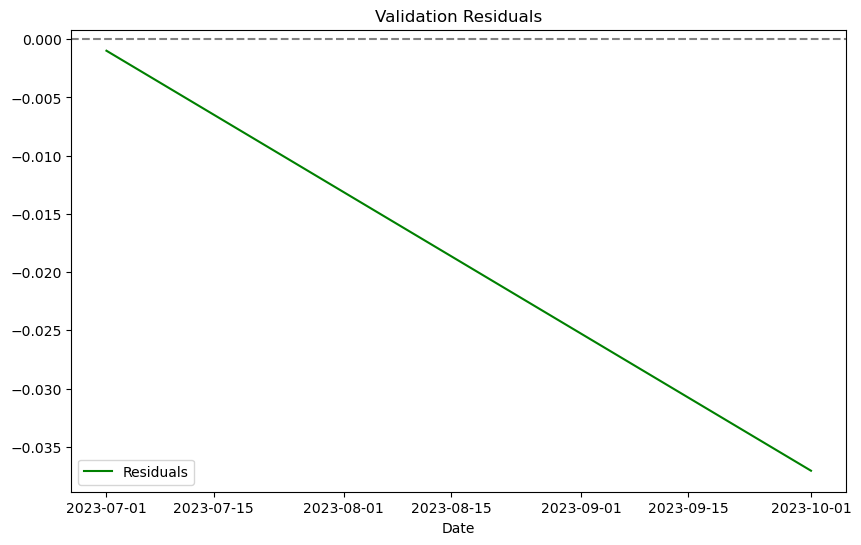

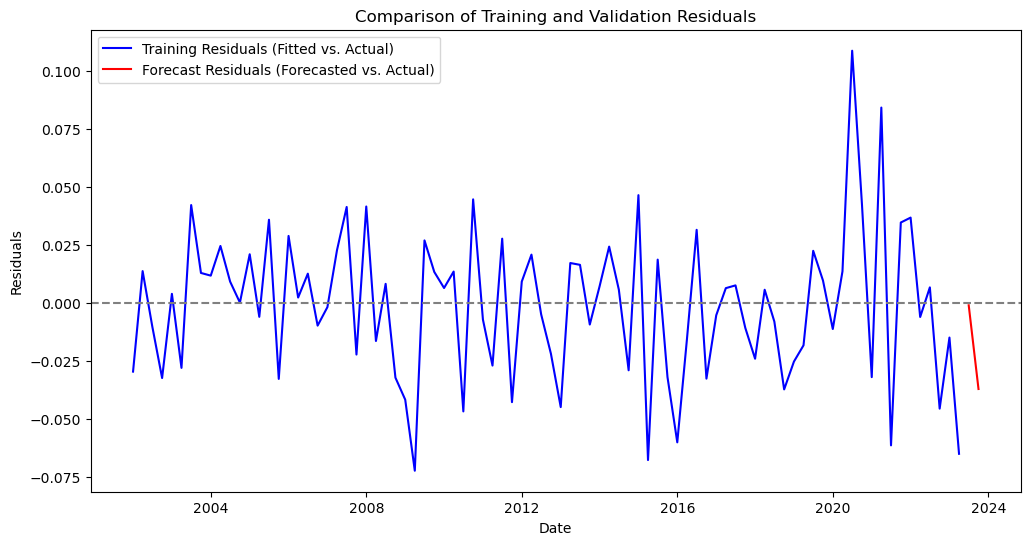

FY 2024 Forecast:


C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



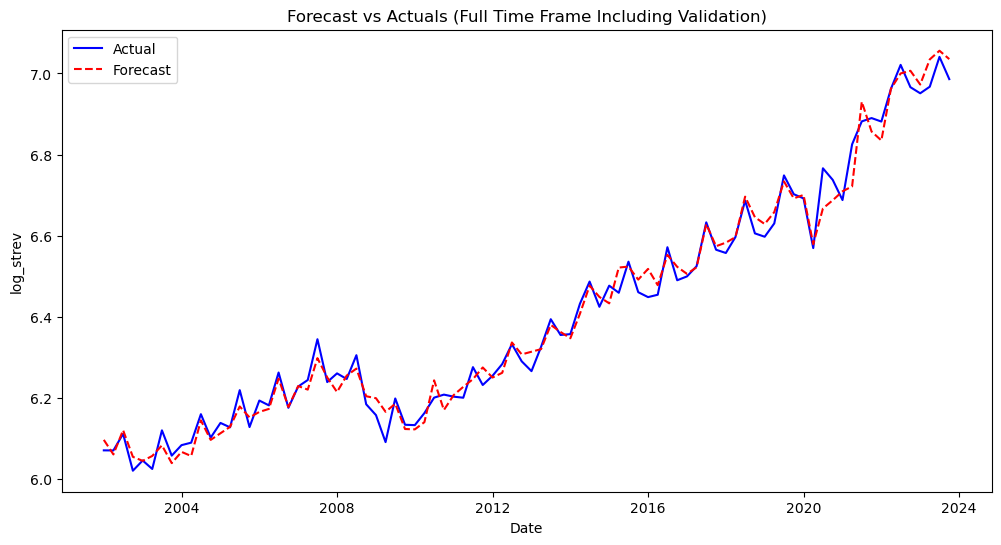

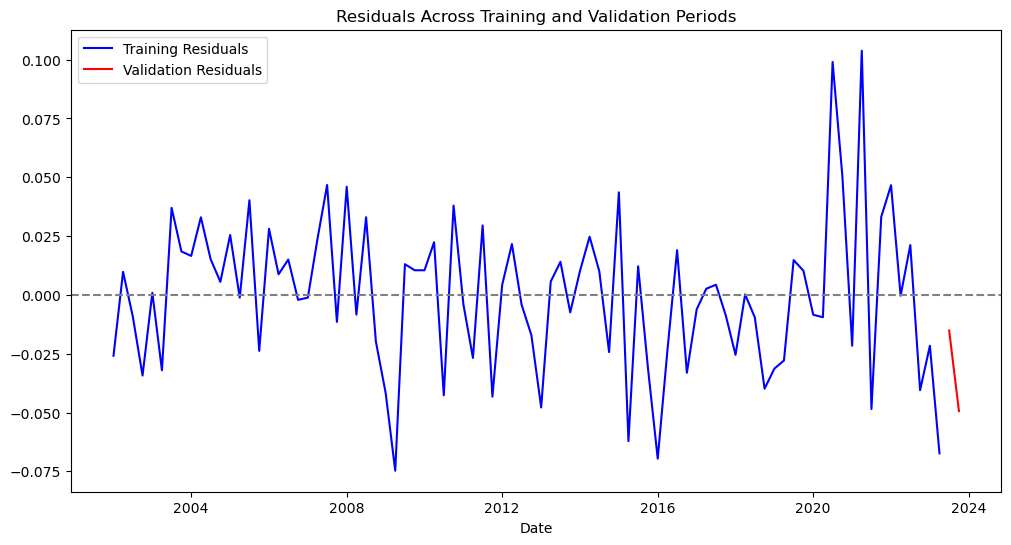

Validation MAE: 0.0323
Validation RMSE: 0.0365
Validation MAPE: 0.46%


C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood 

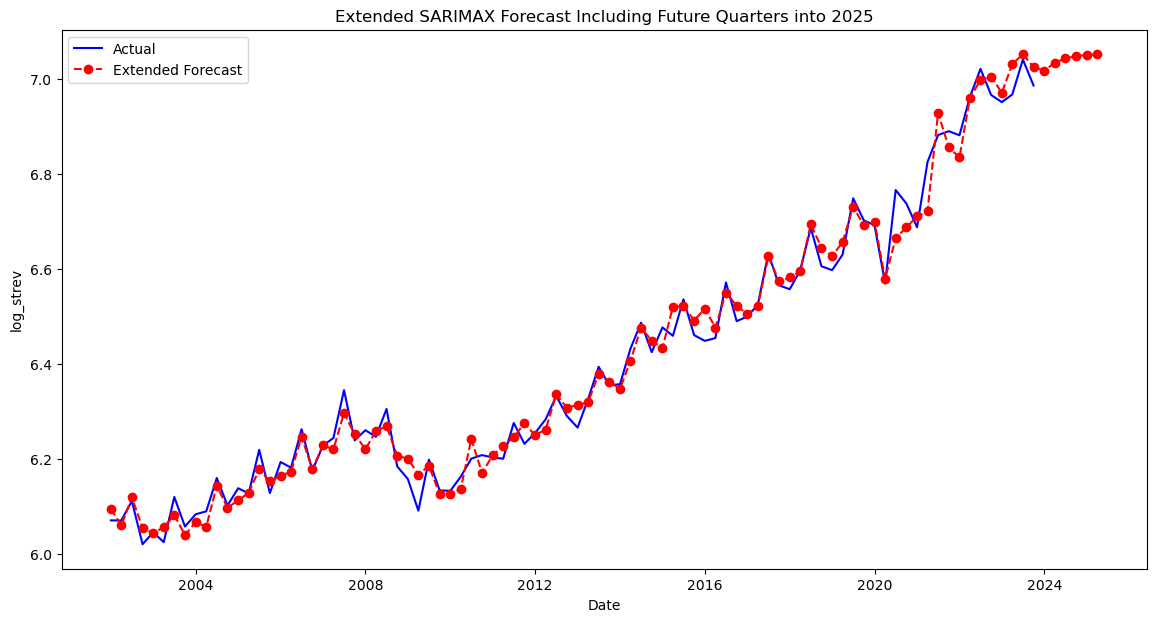

Forecasted values for additional quarters:
2024-01-01: 7.0174
2024-04-01: 7.0341
2024-09-30: 7.0431
2024-12-31: 7.0478
2025-03-31: 7.0503
2025-06-30: 7.0517
Forecasted logged values for upcoming quarters:
2024-01-01: 7.0174
2024-04-01: 7.0341
2024-09-30: 7.0431
2024-12-31: 7.0478
2025-03-31: 7.0503
2025-06-30: 7.0517

Forecasted values on original scale for upcoming quarters:
2024-01-01: 1115.87
2024-04-01: 1134.71
2024-09-30: 1144.88
2024-12-31: 1150.34
2025-03-31: 1153.26
2025-06-30: 1154.82
Forecasted Sales Tax Revenue for FY 2024: 2250.58
Forecasted Sales Tax Revenue for FY 2025: 4603.30
Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): 4474.38


C:\Users\tejer\AppData\Local\Temp\ipykernel_25032\4123136881.py:377: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



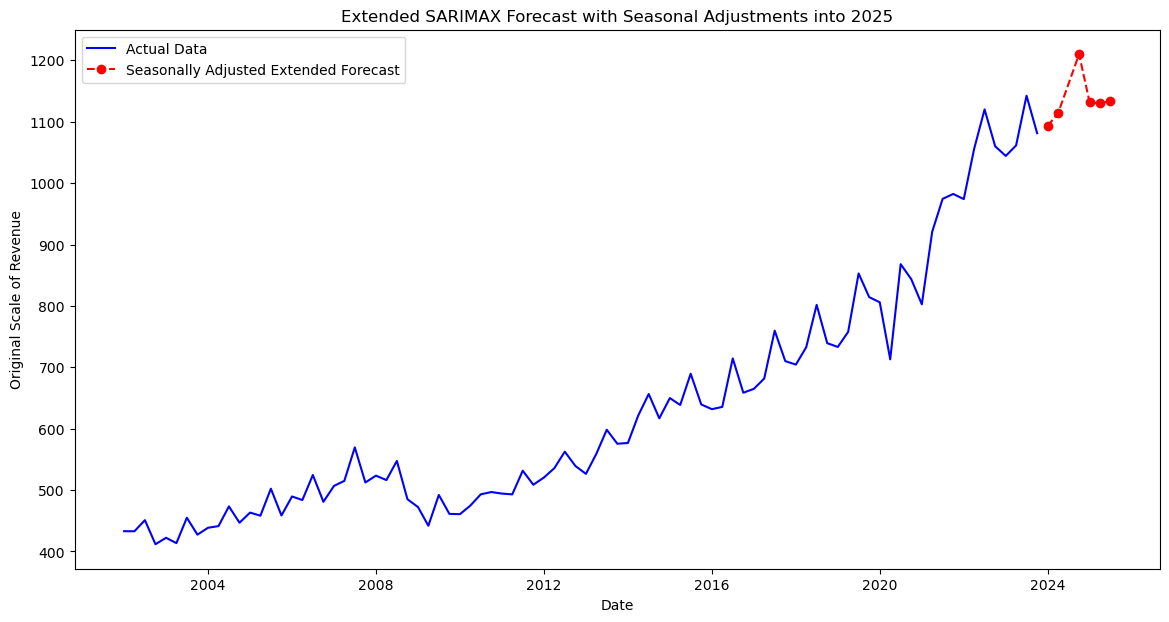


Adjusted forecasted values on original scale for upcoming quarters:
2024-01-01: 1093.16
2024-04-01: 1114.22
2024-09-30: 1210.02
2024-12-31: 1131.46
2025-03-31: 1129.78
2025-06-30: 1133.98
Forecasted Sales Tax Revenue for FY 2024: 2207.38
Forecasted Sales Tax Revenue for FY 2025: 4605.23
Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): 4431.18


In [33]:
# Drop rows with NaN values in the specified columns, including the 'pand' and 'gfc' variables
cleaned_df = df.dropna(subset=['log_strev', 'log_pi', 'log_strev_lag4','pand','gfc','gfc_decay'])

# Define the dependent variable
endog = cleaned_df['log_strev']

# Define the exogenous regressors, include constant for intercept, and add 'pand' and 'gfc' to the exogenous variables
exog = cleaned_df[['log_pi', 'log_strev_lag4','pand','gfc','gfc_decay']]
exog = sm.add_constant(exog)  # adds a constant term to the regressors

# Specify the SARIMAX Model
# Note: (p,d,q) are non-seasonal orders, (P,D,Q,s) are seasonal orders
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1,0,0), seasonal_order=(0,0,0,4), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

# Compute predictions
predictions = results.get_prediction(start=cleaned_df.index[0], end=cleaned_df.index[-1])
predictions_mean = predictions.predicted_mean

# Actual values
actuals = cleaned_df['log_strev']  # or adjust if the actual values are in a different form

# To ignore the first two values, adjust the start of the plot
ignore_first = 2
start_plot_index = actuals.index[ignore_first]

# Compute residuals
residuals = actuals - predictions_mean

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals[ignore_first:]))
mape = np.mean(np.abs(residuals[ignore_first:]) / np.abs(actuals[ignore_first:])) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

# Plot forecast versus actual, ignoring the first two forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actuals.index[ignore_first:], actuals[ignore_first:], label='Actual', color='blue')
plt.plot(predictions_mean.index[ignore_first:], predictions_mean[ignore_first:], label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Plot residuals, ignoring the first two values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index[ignore_first:], residuals[ignore_first:], label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')  # Add horizontal line at y=0 for reference
plt.title('Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Plot ACF of residuals, ignoring the first two observations
plt.figure(figsize=(10, 6))
plot_acf(residuals[2:], lags=20, alpha=0.05)  # Start from the third element of residuals
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Fit the GARCH Model using the residuals of the SARIMAX model
garch = arch_model(results.resid, mean='Zero', vol='Garch', p=1, q=1)
garch_results = garch.fit(update_freq=5, disp='off')

# Print the summary of GARCH model
print(garch_results.summary())

# Obtain the conditional volatility forecasts from GARCH
volatility_forecast = garch_results.conditional_volatility

garch_results.plot()
plt.show()

# Calculate the split point
split_point = int(len(cleaned_df) * 0.98)

# Split the data into training and validation sets
train_df = cleaned_df.iloc[:split_point]
validation_df = cleaned_df.iloc[split_point:]

# Training data endogenous and exogenous variables
train_endog = train_df['log_strev']
train_exog = train_df[['log_pi', 'log_strev_lag4', 'pand', 'gfc_decay','gfc']]
train_exog = sm.add_constant(train_exog)  # Ensure a constant is added

# Fit the SARIMAX model on the training data
model = SARIMAX(train_endog, exog=train_exog, order=(1,0,0), seasonal_order=(1,0,0,4), 
               enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Forecasting
forecast_start = validation_df.index[0]
forecast_end = validation_df.index[-1]
predictions = results.get_prediction(start=forecast_start, end=forecast_end, exog=sm.add_constant(validation_df[['log_pi', 'log_strev_lag4', 'pand','gfc','gfc_decay']]))
predictions_mean = predictions.predicted_mean

# Combine the forecast with the training data predictions for a complete series view
full_predictions = pd.concat([results.fittedvalues, predictions_mean])

# Plot actuals and forecasts
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df['log_strev'], label='Actual', color='blue')
plt.plot(full_predictions, label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Residuals
validation_resid = validation_df['log_strev'] - predictions_mean

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(validation_resid, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Validation Residuals')
plt.xlabel('Date')
plt.legend()
plt.show()

# Calculate metrics
mae = mean_absolute_error(validation_df['log_strev'], predictions_mean)
rmse = mean_squared_error(validation_df['log_strev'], predictions_mean, squared=False)
mape = np.mean(np.abs((validation_df['log_strev'] - predictions_mean) / validation_df['log_strev'])) * 100

# Calculate residuals for training data (fitted values)
training_residuals = train_df['log_strev'] - results.fittedvalues

# Calculate residuals for validation data (forecasted values)
forecast_residuals = validation_df['log_strev'] - predictions_mean

# Combine residuals into a single DataFrame for easier plotting
combined_residuals = pd.concat([training_residuals, forecast_residuals])

# Plotting the residuals from both training and validation datasets with different colors
plt.figure(figsize=(12, 6))

# Plot training residuals in blue
plt.plot(training_residuals.index, training_residuals, label='Training Residuals (Fitted vs. Actual)', color='blue')

# Plot forecast residuals in red
plt.plot(forecast_residuals.index, forecast_residuals, label='Forecast Residuals (Forecasted vs. Actual)', color='red')

# Adding a horizontal line at zero for reference
plt.axhline(0, linestyle='--', color='gray')

# Adding labels and title
plt.title('Comparison of Training and Validation Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Adding a legend to distinguish the plots
plt.legend()

# Display the plot
plt.show()


print('FY 2024 Forecast:')

# Define the cutoff date for the new training and validation split
cutoff_date = pd.Timestamp('2023-07-01')

# Training data will be all data before Q3 2023
train_df = cleaned_df[cleaned_df.index < cutoff_date]

# Validation data will be from Q3 2023 to Q2 2024
validation_df = cleaned_df[(cleaned_df.index >= cutoff_date) & (cleaned_df.index < pd.Timestamp('2024-07-01'))]

# Ensure the exogenous variables include a constant term
train_exog = sm.add_constant(train_df[['log_pi', 'log_strev_lag4', 'pand','gfc','gfc_decay']])
validation_exog = sm.add_constant(validation_df[['log_pi', 'log_strev_lag4', 'pand','gfc','gfc_decay']])

# Fit the SARIMAX model on the new training data
model = SARIMAX(train_df['log_strev'], exog=train_exog, order=(1,0,0), seasonal_order=(0,0,0,4),
               enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Forecast the validation period
predictions = results.get_forecast(steps=len(validation_df), exog=validation_exog)
predictions_mean = predictions.predicted_mean

# Combine the forecast with the training data predictions for a complete series view
full_predictions = pd.concat([results.fittedvalues, predictions_mean])

# Plot the actuals and forecasts for the entire timeframe
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df['log_strev'], label='Actual', color='blue')
plt.plot(full_predictions, label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actuals (Full Time Frame Including Validation)')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Calculate residuals for training and validation
training_residuals = train_df['log_strev'] - results.fittedvalues
validation_residuals = validation_df['log_strev'] - predictions_mean

# Plot residuals for both training and validation periods
plt.figure(figsize=(12, 6))
plt.plot(training_residuals, label='Training Residuals', color='blue')
plt.plot(validation_residuals.index, validation_residuals, label='Validation Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Across Training and Validation Periods')
plt.xlabel('Date')
plt.legend()
plt.show()

# Calculate metrics for the validation period
mae = mean_absolute_error(validation_df['log_strev'], predictions_mean)
rmse = mean_squared_error(validation_df['log_strev'], predictions_mean, squared=False)
mape = np.mean(np.abs((validation_df['log_strev'] - predictions_mean) / validation_df['log_strev'])) * 100

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAPE: {mape:.2f}%")


# Set the training data as all available data
train_df = cleaned_df

# Exogenous variables for training
train_exog = sm.add_constant(train_df[['log_pi', 'log_strev_lag4', 'pand','gfc','gfc_decay']])

# Fit the SARIMAX model on the full dataset available
model = SARIMAX(train_df['log_strev'], exog=train_exog, order=(1,0,0), seasonal_order=(0,0,0,4), 
               enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Define the future dates explicitly for Q1 and Q2 2024
future_dates = pd.to_datetime(['2024-01-01', '2024-04-01'])

# Assume future exogenous variables based on the last observed values
last_observed_exog = train_exog.iloc[-1]  # Last row from training exogenous dataset

# Create a DataFrame for future exogenous variables, replicated for the future periods
future_exog = pd.DataFrame([last_observed_exog] * len(future_dates), index=future_dates)

# Make sure to include constant if it was used in the model
if 'const' in future_exog.columns:
    future_exog['const'] = 1

# Forecasting
model = SARIMAX(train_df['log_strev'], exog=train_exog, order=(1,0,0), seasonal_order=(0,0,0,4), 
               enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

forecast = results.get_forecast(steps=len(future_dates), exog=future_exog)
forecast_mean = forecast.predicted_mean

# Combine the actuals and forecasts into one series for plotting
full_predictions = pd.concat([results.fittedvalues, forecast_mean])

    
    
### FY 2025 Forecast ###    
    
    
# Additional future dates for the second half of 2024 and the first half of 2025
additional_dates = pd.date_range(start='2024-07-01', periods=4, freq='Q')

# Concatenate all future dates
all_future_dates = future_dates.append(additional_dates)

# Assume future exogenous variables continue based on the last observed values
# This example uses the last row from the training exogenous dataset again
additional_future_exog = pd.DataFrame([last_observed_exog] * len(additional_dates), index=additional_dates)

# Combine exogenous variables for all future forecasts
all_future_exog = pd.concat([future_exog, additional_future_exog])

# Make sure to include constant if it was used in the model
if 'const' in all_future_exog.columns:
    all_future_exog['const'] = 1

# Forecasting including additional future quarters
extended_forecast = results.get_forecast(steps=len(all_future_dates), exog=all_future_exog)
extended_forecast_mean = extended_forecast.predicted_mean

# Combine the actuals and extended forecasts into one series for plotting
full_extended_predictions = pd.concat([results.fittedvalues, extended_forecast_mean])

# Plot the actual data and the extended forecast
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df['log_strev'], label='Actual', color='blue')
plt.plot(full_extended_predictions, label='Extended Forecast', linestyle='--', color='red', marker='o')
plt.title('Extended SARIMAX Forecast Including Future Quarters into 2025')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Print forecasted values for all future dates
print("Forecasted values for additional quarters:")
for date, value in zip(all_future_dates, extended_forecast_mean):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.4f}")
    

# Forecasted values for all future dates (logged)
print("Forecasted logged values for upcoming quarters:")
for date, value in zip(all_future_dates, extended_forecast_mean):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.4f}")

# Applying exponential to convert logged values back to the original scale
inverse_log_forecast = np.exp(extended_forecast_mean)

# Print the original scale forecasted values
print("\nForecasted values on original scale for upcoming quarters:")
for date, value in zip(all_future_dates, inverse_log_forecast):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")
    
# Dates and forecasted values
forecast_dates = pd.DatetimeIndex(all_future_dates)
forecast_values = np.exp(extended_forecast_mean)  # Inversing the log to get original scale values

# Creating a DataFrame for ease of manipulation
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_values})

# Summing values for Fiscal Year 2024 (Second half of 2023 and First half of 2024)
fy_2024 = forecast_df[(forecast_df['Date'] >= '2023-07-01') & (forecast_df['Date'] < '2024-07-01')]['Forecast_Values'].sum()

# Summing values for Fiscal Year 2025 (Second half of 2024 and First half of 2025)
fy_2025 = forecast_df[(forecast_df['Date'] >= '2024-07-01') & (forecast_df['Date'] < '2025-07-01')]['Forecast_Values'].sum()

# Print the summed forecasted values for fiscal years
print(f"Forecasted Sales Tax Revenue for FY 2024: {fy_2024:.2f}")
print(f"Forecasted Sales Tax Revenue for FY 2025: {fy_2025:.2f}")

# Extract observed values for Q3 2023 and Q4 2023 from the actual data
observed_fy_2024 = cleaned_df[(cleaned_df.index >= '2023-07-01') & (cleaned_df.index < '2024-01-01')]['log_strev'].apply(np.exp).sum()

# Dates and forecasted values (ensure these have already been calculated and forecasted from previous steps)
forecast_dates = pd.DatetimeIndex(all_future_dates)
forecast_values = np.exp(extended_forecast_mean)  # Inverse the log to get the original scale values

# Creating a DataFrame for ease of manipulation
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_values})

# Summing forecasted values for First half of 2024
forecasted_fy_2024 = forecast_df[(forecast_df['Date'] >= '2024-01-01') & (forecast_df['Date'] < '2024-07-01')]['Forecast_Values'].sum()

# Total Fiscal Year 2024 revenue includes observed and forecasted values
total_fy_2024_revenue = observed_fy_2024 + forecasted_fy_2024

# Print the summed forecasted values for fiscal year 2024 including observed values
print(f"Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): {total_fy_2024_revenue:.2f}")

# Assuming 'log_strev' is the logged series used in the model
decomposition = seasonal_decompose(cleaned_df['log_strev'], model='additive', period=4)  # Ensure period matches your data's seasonality

# Extract the seasonal component
seasonal = decomposition.seasonal[-4:]  # Get the last year's seasonal effect

# Predicting future points, assuming 'extended_forecast_mean' is your forecasted log data
num_forecasts = len(all_future_dates)  # Total number of forecasts needed
repeated_seasonal = np.tile(seasonal, int(np.ceil(num_forecasts / 4)))[:num_forecasts]  # Repeat and trim seasonal effects

# Apply seasonal effects to the forecast
adjusted_forecast = extended_forecast_mean + repeated_seasonal

# Transform forecast back to original scale
adjusted_forecast_original = np.exp(adjusted_forecast)

# Plotting the adjusted forecast
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, np.exp(cleaned_df['log_strev']), label='Actual Data', color='blue')
plt.plot(all_future_dates, adjusted_forecast_original, 'r--', label='Seasonally Adjusted Extended Forecast', color='red', marker='o')
plt.title('Extended SARIMAX Forecast with Seasonal Adjustments into 2025')
plt.xlabel('Date')
plt.ylabel('Original Scale of Revenue')
plt.legend()
plt.show()

# Print adjusted forecasted values
print("\nAdjusted forecasted values on original scale for upcoming quarters:")
for date, value in zip(all_future_dates, adjusted_forecast_original):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")
    
    
# Assuming the forecast dates and values have been established
forecast_dates = pd.DatetimeIndex(all_future_dates)
forecast_values = adjusted_forecast_original  # Using the adjusted forecast from the earlier example

# Creating a DataFrame for ease of manipulation
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_values})

# Define fiscal year cutoffs
fy_cutoffs = {
    'FY 2024': {'start': '2023-07-01', 'end': '2024-06-30'},
    'FY 2025': {'start': '2024-07-01', 'end': '2025-06-30'}
}

# Calculate forecasted values for each fiscal year
for fy, dates in fy_cutoffs.items():
    fy_forecast = forecast_df[(forecast_df['Date'] >= dates['start']) & (forecast_df['Date'] <= dates['end'])]['Forecast_Values'].sum()
    print(f"Forecasted Sales Tax Revenue for {fy}: {fy_forecast:.2f}")

# Calculate observed values from actual data for partial FY 2024 (if available)
observed_fy_2024 = cleaned_df[(cleaned_df.index >= pd.Timestamp('2023-07-01')) & (cleaned_df.index <= pd.Timestamp('2023-12-31'))]['log_strev'].apply(np.exp).sum()

# Summing forecasted values for the first half of 2024
forecasted_fy_2024 = forecast_df[(forecast_df['Date'] >= '2024-01-01') & (forecast_df['Date'] <= '2024-06-30')]['Forecast_Values'].sum()

# Total Fiscal Year 2024 revenue includes observed and forecasted values
total_fy_2024_revenue = observed_fy_2024 + forecasted_fy_2024

# Print the summed forecasted values for fiscal year 2024 including observed values
print(f"Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): {total_fy_2024_revenue:.2f}")

**Conclusion:** The model appears successful at forecasting on trend. It has a low MAPE of less than 50 basis points with balanced residuals and minimal GARCH effects. Thereis additional room to improve the model around the pandemic and great financial crisis adjustments.

The remainder of the code evaluates other models.

# Model 4: Holt Winters

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



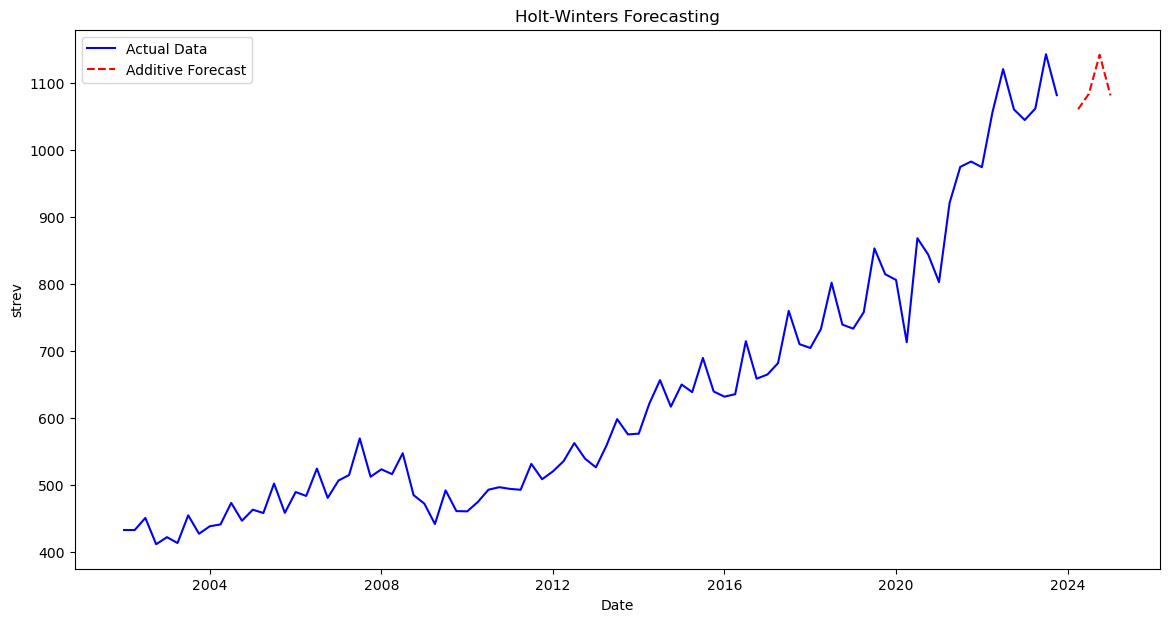

MAE: 18.1079
MAPE: 2.73%


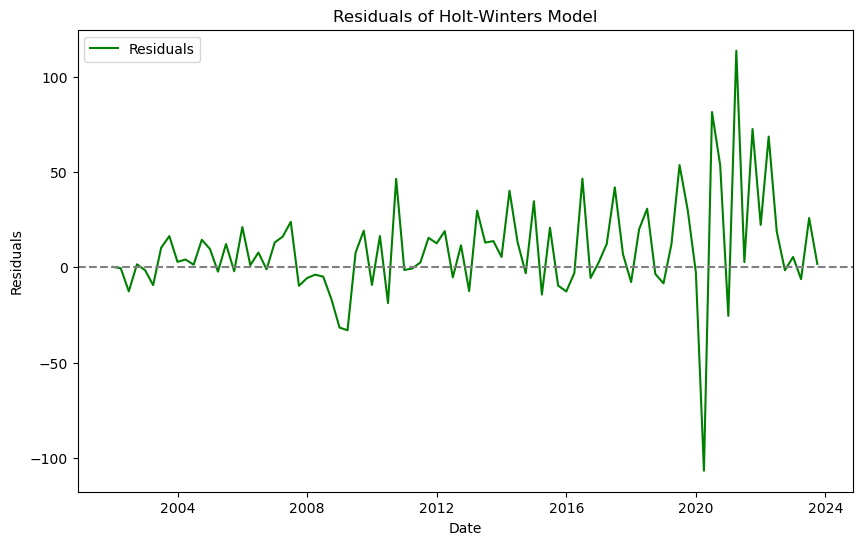

In [34]:
# Fit the model - Additive
model_add = ExponentialSmoothing(cleaned_df['strev'], seasonal='add', seasonal_periods=4).fit()

# Forecast next 4 periods
forecast_add = model_add.forecast(4)

# Plot the historical data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=5, freq='Q')[1:], forecast_add, label='Additive Forecast', color='red', linestyle='--')

plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate residuals
residuals_add = cleaned_df['strev'] - model_add.fittedvalues

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals_add))
mape = np.mean(np.abs(residuals_add / cleaned_df['strev'])) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_add, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

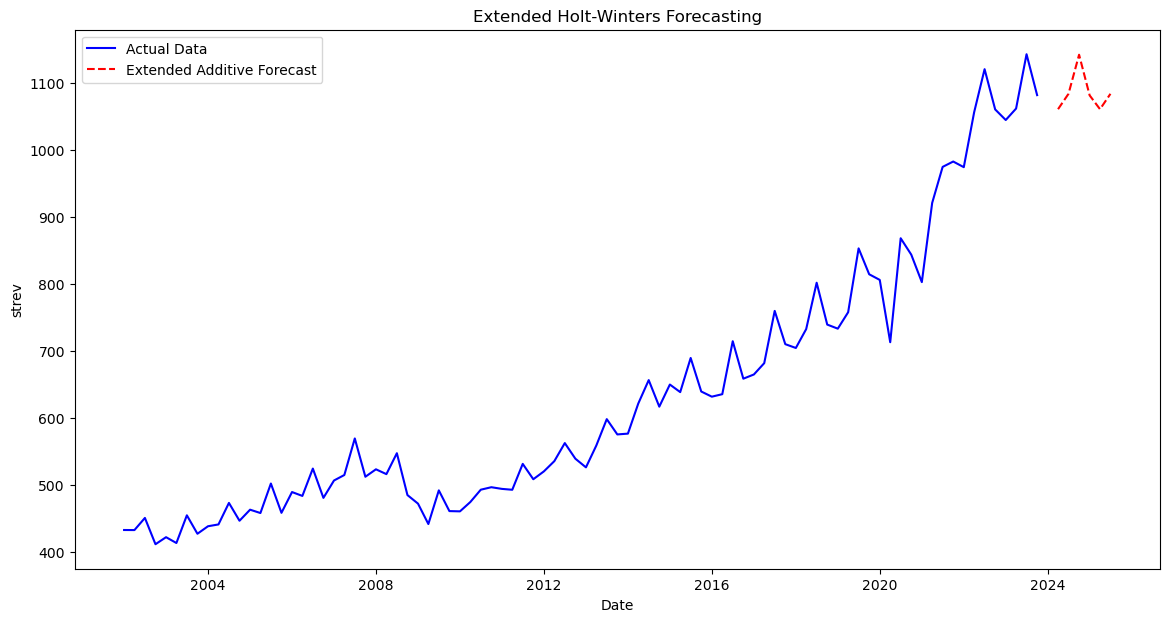

Extended Forecasted values:
2024-03-31: 1060.44
2024-06-30: 1083.38
2024-09-30: 1141.65
2024-12-31: 1081.01
2025-03-31: 1060.44
2025-06-30: 1083.38


C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



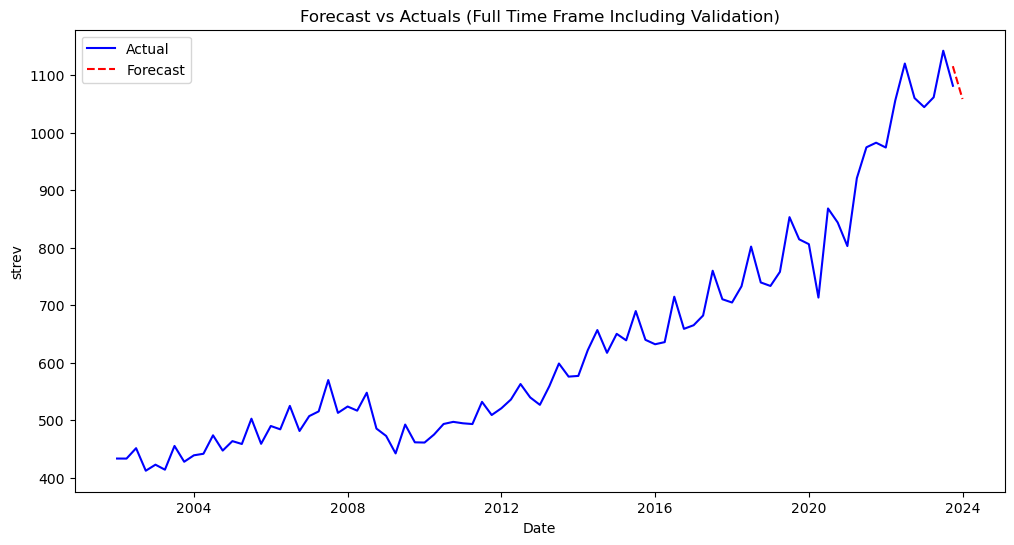

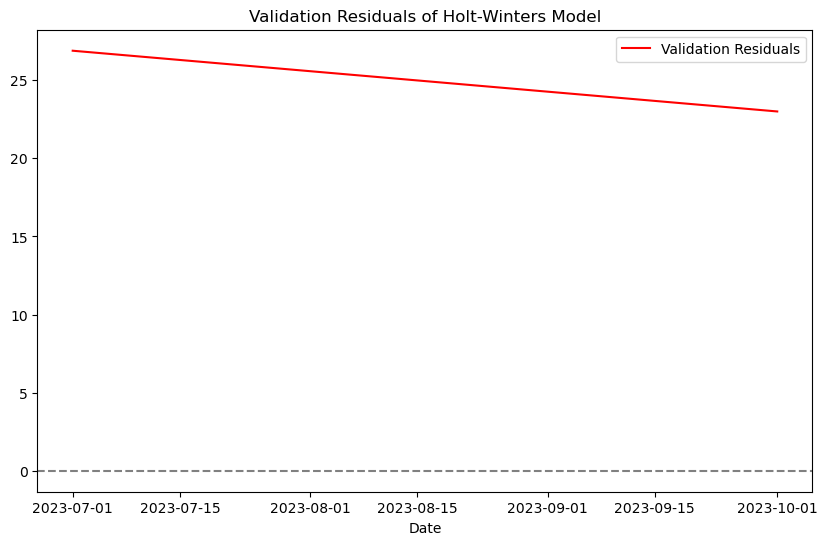

Forecasted values for upcoming quarters:
2024-01-01: 1060.4353
2024-04-01: 1083.3802
2024-09-30: 1141.6459
2024-12-31: 1081.0132
2025-03-31: 1060.4353
2025-06-30: 1083.3802


In [35]:
# To extend the forecast to 6 periods for comparison:
extended_forecast_add = model_add.forecast(6)

# Plot the extended forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_add, label='Extended Additive Forecast', color='red', linestyle='--')
plt.title('Extended Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate and print additional forecasted values
print("Extended Forecasted values:")
for date, value in zip(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_add):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

# Define the cutoff date for the new training and validation split
cutoff_date = pd.Timestamp('2023-07-01')

# Training data will be all data before Q3 2023
train_df = cleaned_df[cleaned_df.index < cutoff_date]

# Validation data will be from Q3 2023 to Q2 2024
validation_df = cleaned_df[(cleaned_df.index >= cutoff_date) & (cleaned_df.index < pd.Timestamp('2024-07-01'))]

# Fit the Holt-Winters model on the new training data
model_hw = ExponentialSmoothing(train_df['strev'], seasonal='add', seasonal_periods=4).fit()

# Forecast the validation period
predictions_hw = model_hw.forecast(len(validation_df))

# Plot the actuals and forecasts for the entire timeframe
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df['strev'], label='Actual', color='blue')
plt.plot(pd.date_range(train_df.index[-1] + pd.offsets.QuarterEnd(), periods=len(validation_df) + 1, freq='Q')[1:], predictions_hw, label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actuals (Full Time Frame Including Validation)')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Residuals for validation period
validation_residuals_hw = validation_df['strev'] - predictions_hw

# Plot residuals for the validation period
plt.figure(figsize=(10, 6))
plt.plot(validation_residuals_hw, label='Validation Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Validation Residuals of Holt-Winters Model')
plt.xlabel('Date')
plt.legend()
plt.show()


# Print forecasted logged values for upcoming quarters
print("Forecasted values for upcoming quarters:")
for date, value in zip(all_future_dates, extended_forecast_add):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.4f}")

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



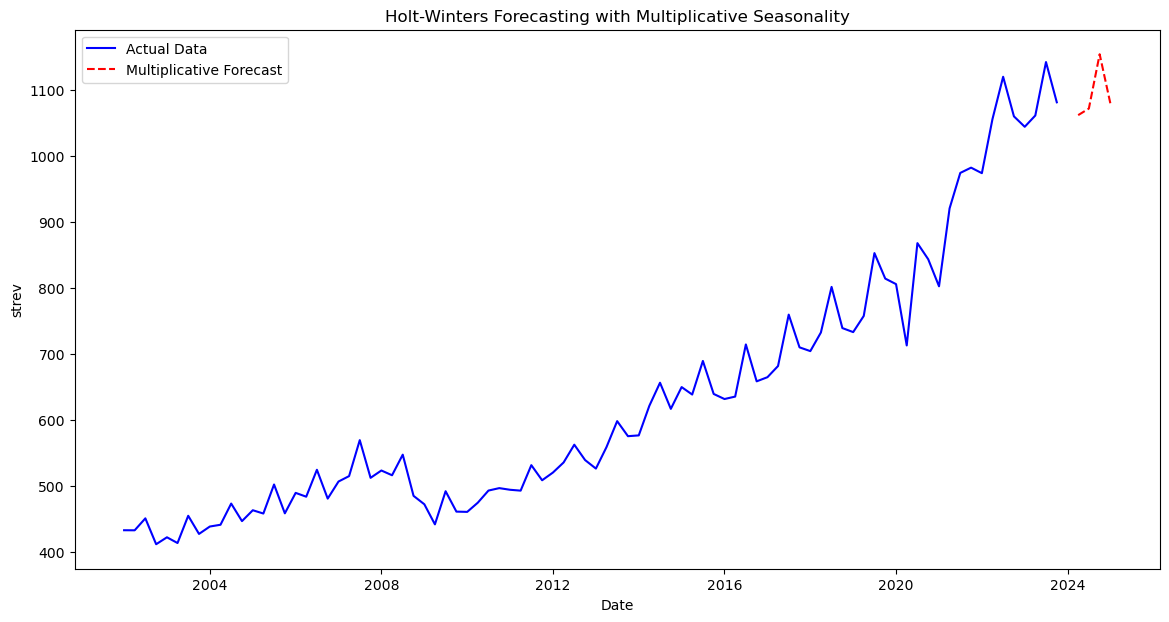

MAE: 17.3428
MAPE: 2.69%


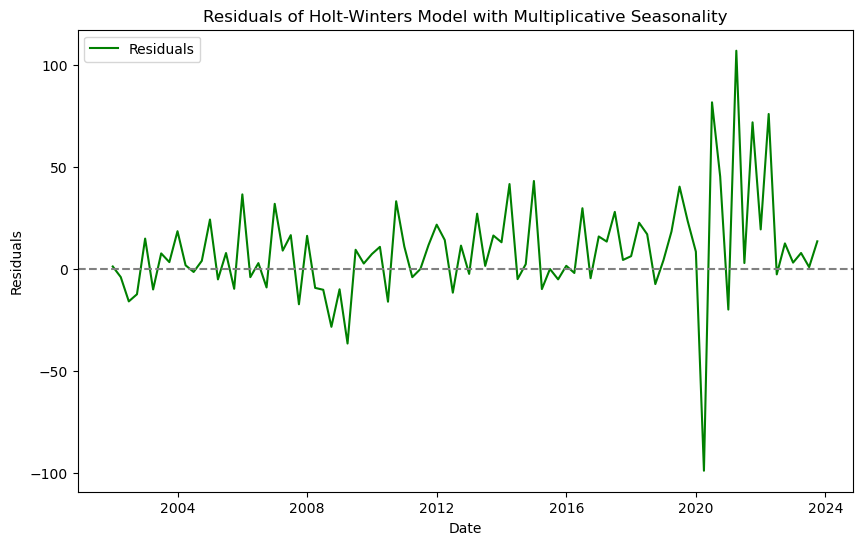

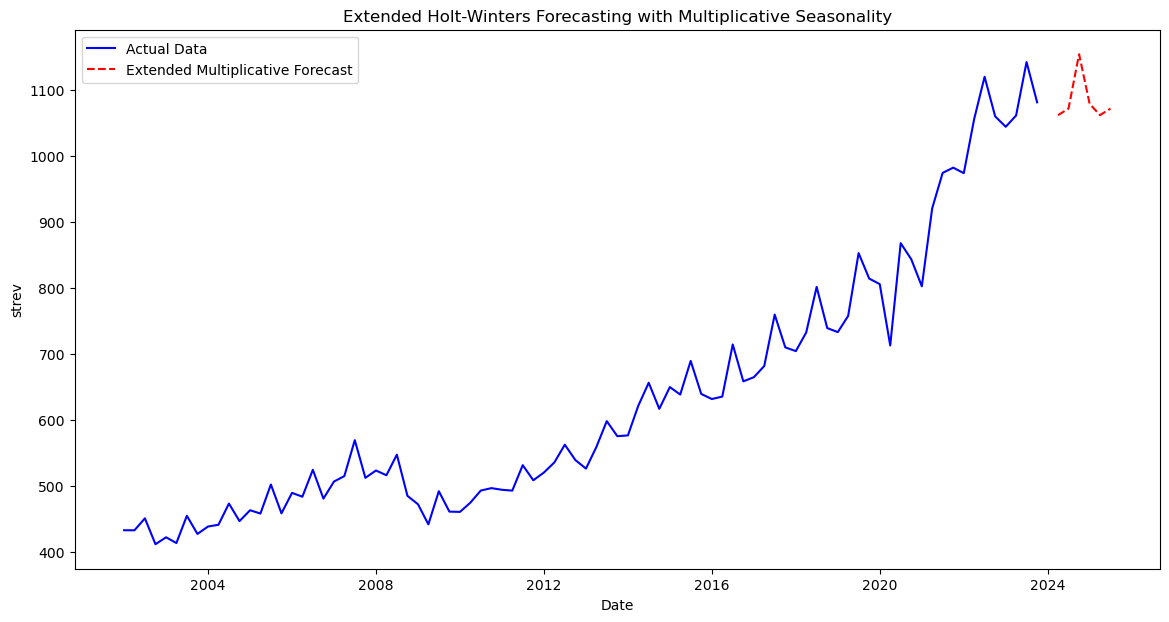

Extended Forecasted values:
2024-03-31: 1061.95
2024-06-30: 1071.91
2024-09-30: 1154.26
2024-12-31: 1079.05
2025-03-31: 1061.95
2025-06-30: 1071.91


C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



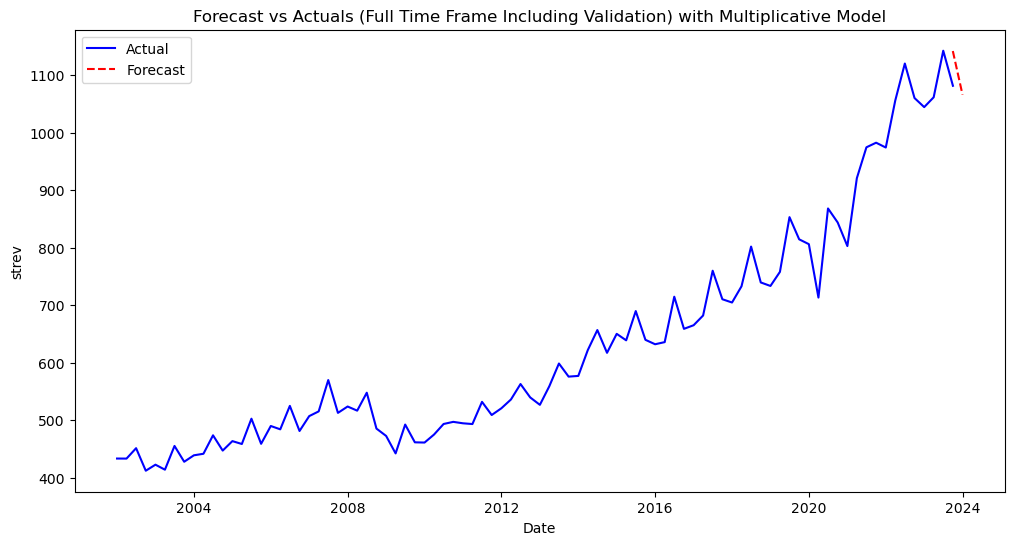

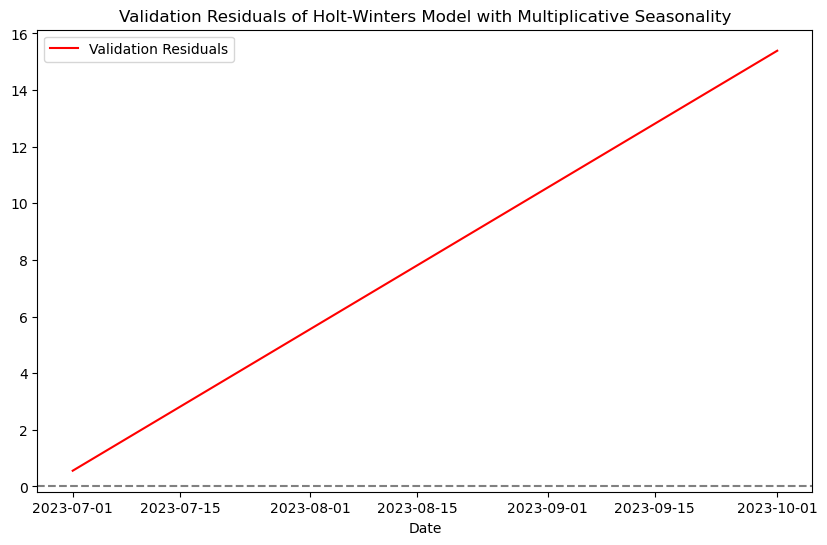

In [36]:
# Fit the model - Multiplicative
model_mul = ExponentialSmoothing(cleaned_df['strev'], seasonal='mul', seasonal_periods=4).fit()

# Forecast next 4 periods
forecast_mul = model_mul.forecast(4)

# Plot the historical data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=5, freq='Q')[1:], forecast_mul, label='Multiplicative Forecast', color='red', linestyle='--')

plt.title('Holt-Winters Forecasting with Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate residuals
residuals_mul = cleaned_df['strev'] - model_mul.fittedvalues

# Calculate MAE and MAPE using the non-ignored values
mae = np.mean(np.abs(residuals_mul))
mape = np.mean(np.abs(residuals_mul / cleaned_df['strev'])) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_mul, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of Holt-Winters Model with Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# To extend the forecast to 6 periods for comparison:
extended_forecast_mul = model_mul.forecast(6)

# Plot the extended forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_mul, label='Extended Multiplicative Forecast', color='red', linestyle='--')
plt.title('Extended Holt-Winters Forecasting with Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate and print additional forecasted values
print("Extended Forecasted values:")
for date, value in zip(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_mul):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

# Fit the Holt-Winters model on the new training data using multiplicative seasonality
model_hw_mul = ExponentialSmoothing(train_df['strev'], seasonal='mul', seasonal_periods=4).fit()

# Forecast the validation period using the multiplicative model
predictions_hw_mul = model_hw_mul.forecast(len(validation_df))

# Plot the actuals and forecasts for the entire timeframe using the multiplicative model
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df['strev'], label='Actual', color='blue')
plt.plot(pd.date_range(train_df.index[-1] + pd.offsets.QuarterEnd(), periods=len(validation_df) + 1, freq='Q')[1:], predictions_hw_mul, label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actuals (Full Time Frame Including Validation) with Multiplicative Model')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate residuals for the validation period using the multiplicative model
validation_residuals_hw_mul = validation_df['strev'] - predictions_hw_mul

# Plot residuals for the validation period using the multiplicative model
plt.figure(figsize=(10, 6))
plt.plot(validation_residuals_hw_mul, label='Validation Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Validation Residuals of Holt-Winters Model with Multiplicative Seasonality')
plt.xlabel('Date')
plt.legend()
plt.show()


**Conclusion:** The Holt Winters additive model does not seem to capture the growth trend. This leads to large residuals in the later periods.

# Model 5: Holt Winters Multiplicative

C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



AIC of the Holt-Winters model: -565.1313759072822


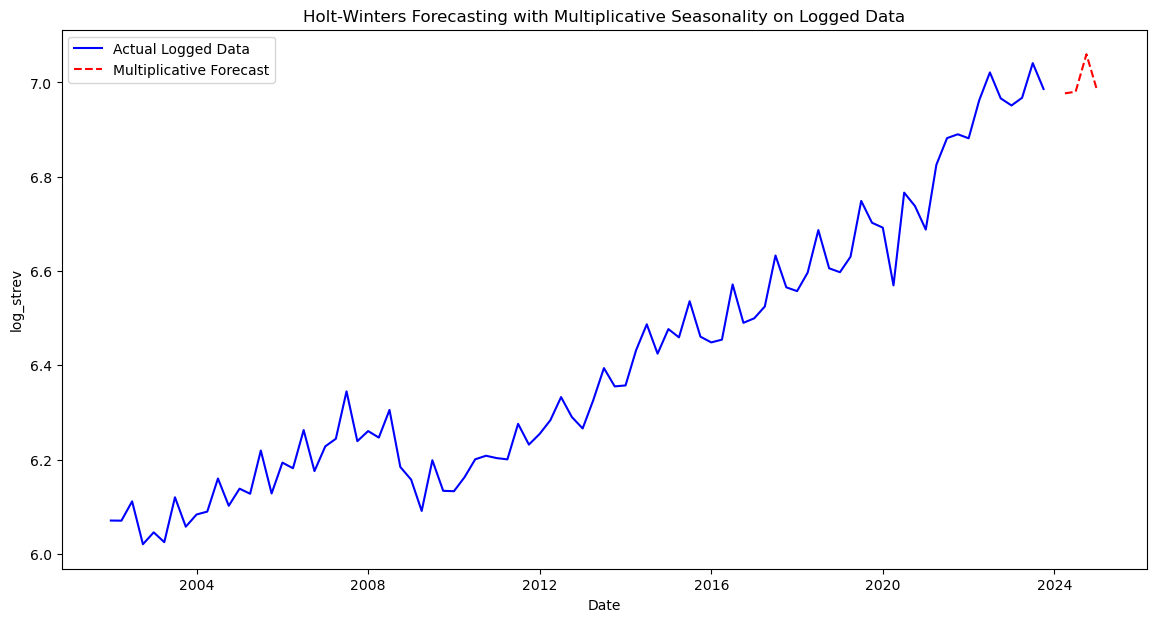

MAE: 0.0266
MAPE: 0.41%


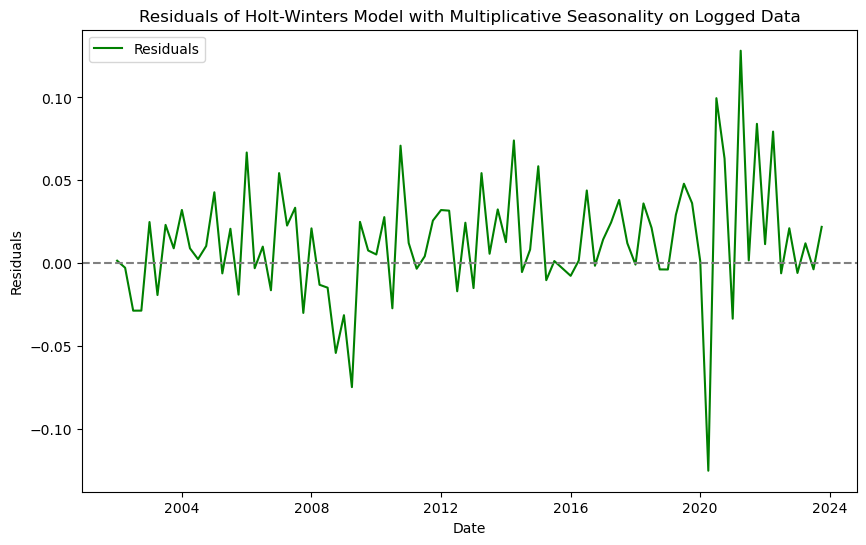

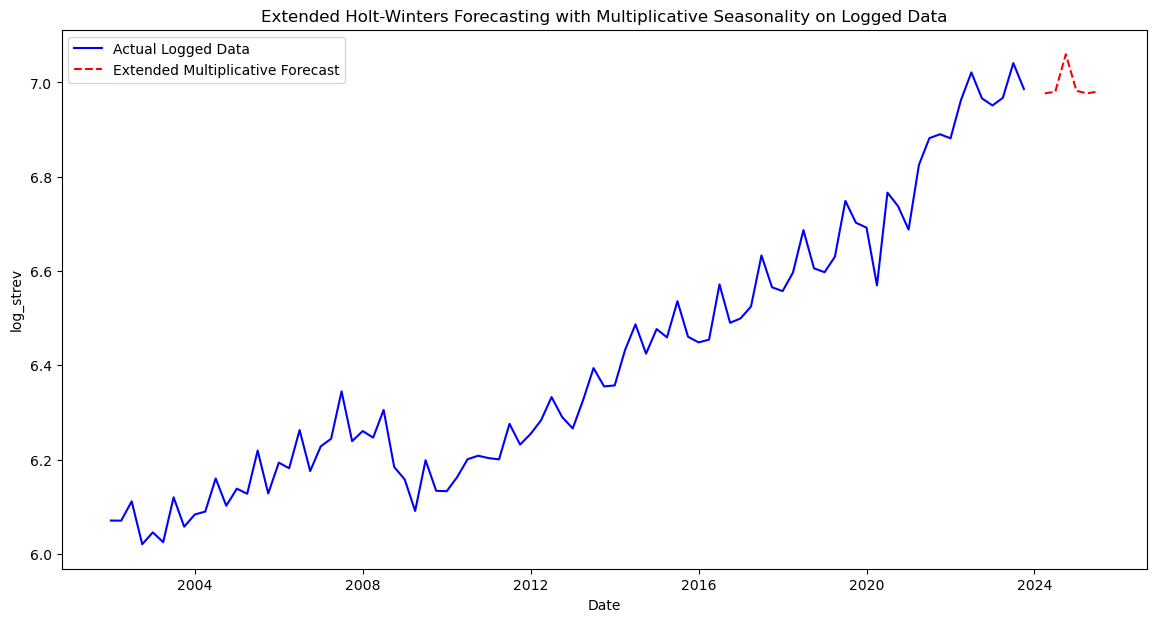

Extended Forecasted logged values:
2024-03-31: 6.9769
2024-06-30: 6.9802
2024-09-30: 7.0598
2024-12-31: 6.9822
2025-03-31: 6.9769
2025-06-30: 6.9802


C:\Users\tejer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



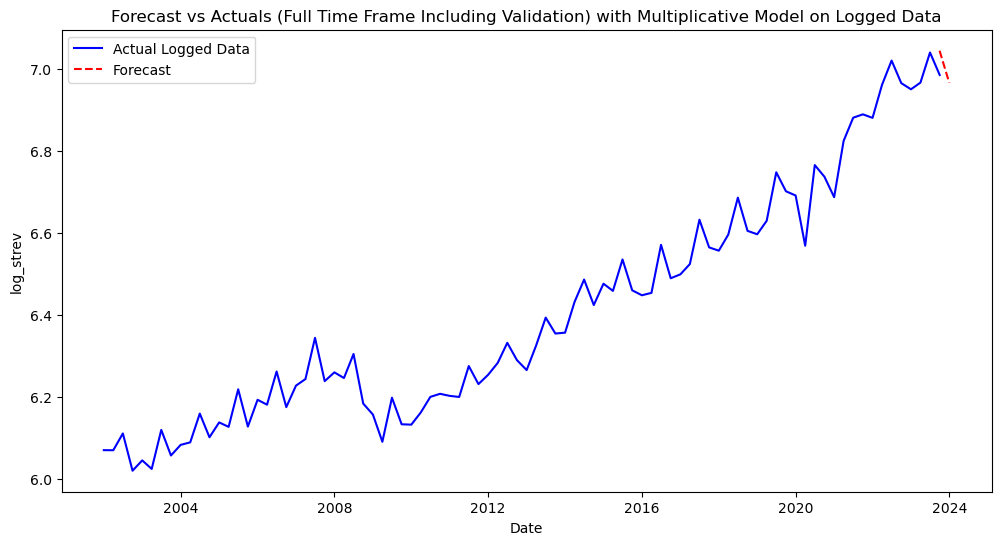

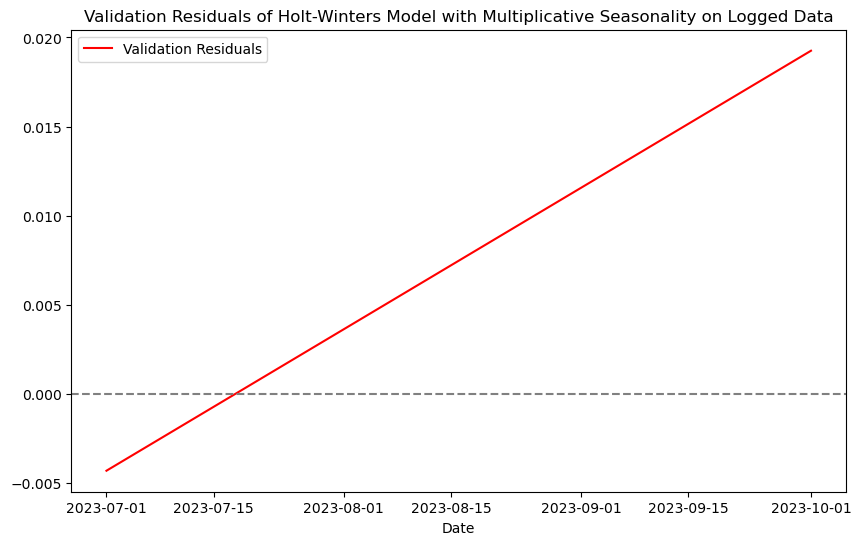

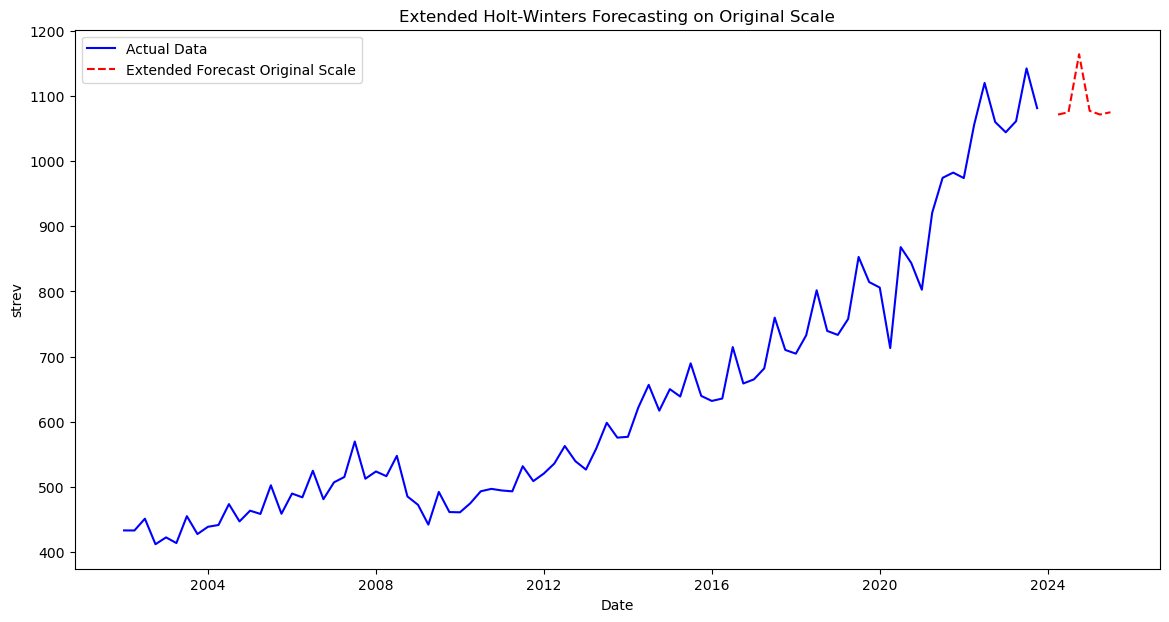

Extended Forecasted values on Original Scale:
2024-03-31: 1071.54
2024-06-30: 1075.08
2024-09-30: 1164.17
2024-12-31: 1077.27
2025-03-31: 1071.54
2025-06-30: 1075.08
Forecasted Sales Tax Revenue for FY 2024: 2146.62
Forecasted Sales Tax Revenue for FY 2025: 4388.06
Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): 5536.78
Forecasted Sales Tax Revenue for FY 2025: 4388.06


C:\Users\tejer\AppData\Local\Temp\ipykernel_25032\1135799294.py:150: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



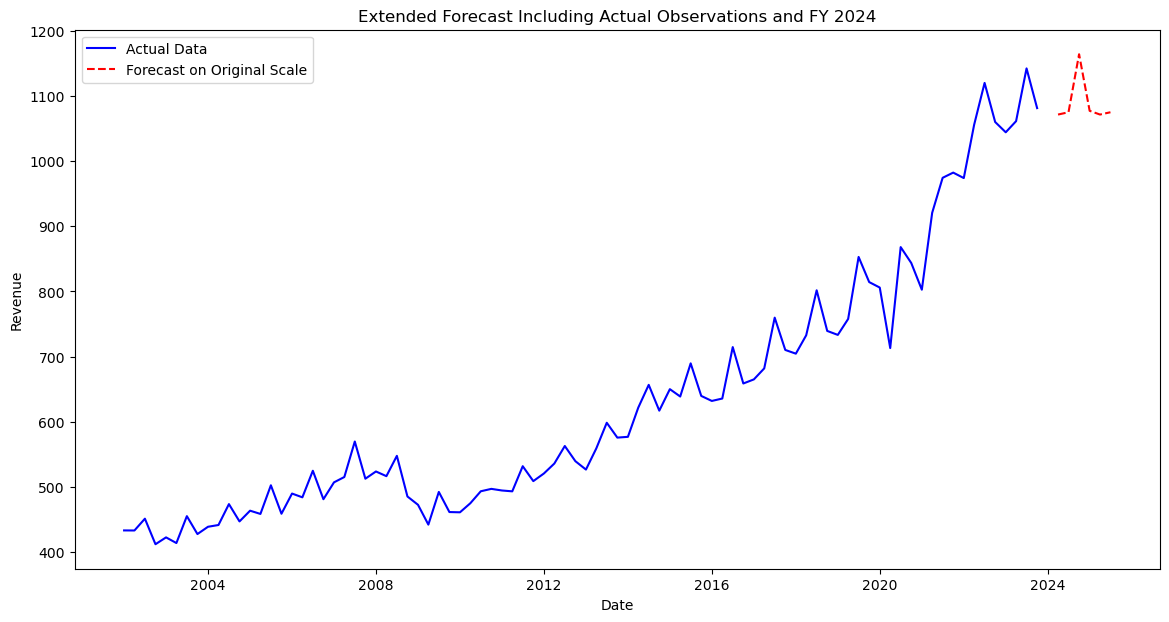

<Figure size 1000x600 with 0 Axes>

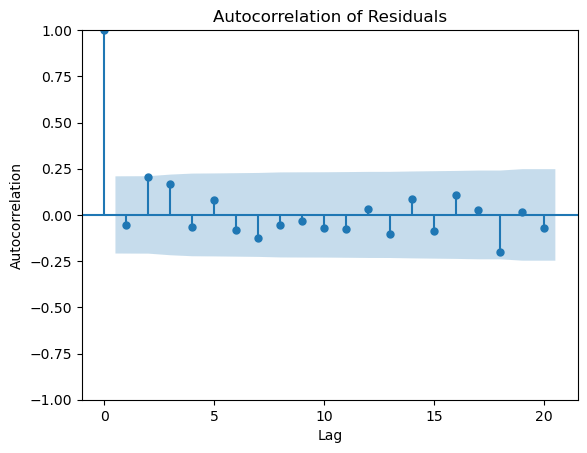

In [37]:
# Fit the model - Multiplicative on logged data
model_mul = ExponentialSmoothing(cleaned_df['log_strev'], seasonal='mul', seasonal_periods=4).fit()

# Display the AIC of the model
print("AIC of the Holt-Winters model:", model_mul.aic)

# Forecast next 4 periods
forecast_mul = model_mul.forecast(4)

# Plot the historical logged data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['log_strev'], label='Actual Logged Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=5, freq='Q')[1:], forecast_mul, label='Multiplicative Forecast', color='red', linestyle='--')
plt.title('Holt-Winters Forecasting with Multiplicative Seasonality on Logged Data')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Calculate residuals on logged data
residuals_mul = cleaned_df['log_strev'] - model_mul.fittedvalues

# Calculate MAE and MAPE using the non-ignored values on logged data
mae = np.mean(np.abs(residuals_mul))
mape = np.mean(np.abs(residuals_mul / cleaned_df['log_strev'])) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot residuals on logged data
plt.figure(figsize=(10, 6))
plt.plot(residuals_mul, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of Holt-Winters Model with Multiplicative Seasonality on Logged Data')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# To extend the forecast to 6 periods for comparison:
extended_forecast_mul = model_mul.forecast(6)

# Plot the extended forecasts on logged data
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['log_strev'], label='Actual Logged Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_mul, label='Extended Multiplicative Forecast', color='red', linestyle='--')
plt.title('Extended Holt-Winters Forecasting with Multiplicative Seasonality on Logged Data')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Calculate and print additional forecasted logged values
print("Extended Forecasted logged values:")
for date, value in zip(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], extended_forecast_mul):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.4f}")

# Fit the Holt-Winters model on the new training data using multiplicative seasonality on logged data
model_hw_mul = ExponentialSmoothing(train_df['log_strev'], seasonal='mul', seasonal_periods=4).fit()

# Forecast the validation period using the multiplicative model on logged data
predictions_hw_mul = model_hw_mul.forecast(len(validation_df))

# Plot the actuals and forecasts for the entire timeframe using the multiplicative model on logged data
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df['log_strev'], label='Actual Logged Data', color='blue')
plt.plot(pd.date_range(train_df.index[-1] + pd.offsets.QuarterEnd(), periods=len(validation_df) + 1, freq='Q')[1:], predictions_hw_mul, label='Forecast', linestyle='--', color='red')
plt.title('Forecast vs Actuals (Full Time Frame Including Validation) with Multiplicative Model on Logged Data')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Calculate residuals for the validation period using the multiplicative model on logged data
validation_residuals_hw_mul = validation_df['log_strev'] - predictions_hw_mul

# Plot residuals for the validation period using the multiplicative model on logged data
plt.figure(figsize=(10, 6))
plt.plot(validation_residuals_hw_mul, label='Validation Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Validation Residuals of Holt-Winters Model with Multiplicative Seasonality on Logged Data')
plt.xlabel('Date')
plt.legend()
plt.show()

# Transform the logged forecast back to the original scale
forecast_original_scale = np.exp(extended_forecast_mul)

# Plot the extended forecasts on the original scale
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, np.exp(cleaned_df['log_strev']), label='Actual Data', color='blue')
plt.plot(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], forecast_original_scale, label='Extended Forecast Original Scale', color='red', linestyle='--')
plt.title('Extended Holt-Winters Forecasting on Original Scale')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Print extended forecasted values on the original scale
print("Extended Forecasted values on Original Scale:")
for date, value in zip(pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:], forecast_original_scale):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

# Creating a DataFrame for ease of manipulation
forecast_dates = pd.date_range(cleaned_df.index[-1] + pd.offsets.QuarterEnd(), periods=7, freq='Q')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_original_scale})

# Define fiscal years
fy_2024_start = pd.Timestamp('2023-07-01')
fy_2025_start = pd.Timestamp('2024-07-01')
fy_2025_end = pd.Timestamp('2025-06-30')

# Summing forecasted values for Fiscal Year 2024 and 2025
fy_2024_forecast = forecast_df[(forecast_df['Date'] >= fy_2024_start) & (forecast_df['Date'] < fy_2025_start)]['Forecast_Values'].sum()
fy_2025_forecast = forecast_df[(forecast_df['Date'] >= fy_2025_start) & (forecast_df['Date'] <= fy_2025_end)]['Forecast_Values'].sum()

# Print the summed forecasted values for fiscal years
print(f"Forecasted Sales Tax Revenue for FY 2024: {fy_2024_forecast:.2f}")
print(f"Forecasted Sales Tax Revenue for FY 2025: {fy_2025_forecast:.2f}")


# Convert 'log_strev' back to original scale for actual data
cleaned_df['strev'] = np.exp(cleaned_df['log_strev'])

# Define fiscal year boundaries
fy_2024_start = pd.Timestamp('2023-07-01')
fy_2025_start = pd.Timestamp('2024-07-01')
fy_2025_end = pd.Timestamp('2025-06-30')

# Extract observed values for Q3 and Q4 2023 from the actual data
observed_fy_2024 = cleaned_df[(cleaned_df.index >= fy_2024_start) & (cleaned_df.index < fy_2025_start)]['strev'].sum()

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_original_scale})

# Summing forecasted values for Fiscal Year 2024 and 2025
fy_2024_forecast = forecast_df[(forecast_df['Date'] >= fy_2025_start) & (forecast_df['Date'] < fy_2025_end)]['Forecast_Values'].sum()
fy_2025_forecast = forecast_df[(forecast_df['Date'] >= fy_2025_start) & (forecast_df['Date'] <= fy_2025_end)]['Forecast_Values'].sum()

# Combine observed and forecasted revenues for FY 2024
total_fy_2024_revenue = observed_fy_2024 + fy_2024_forecast

# Print the summed forecasted values for fiscal years including the observed data
print(f"Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): {total_fy_2024_revenue:.2f}")
print(f"Forecasted Sales Tax Revenue for FY 2025: {fy_2025_forecast:.2f}")

# Plotting the data with the forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(forecast_dates, forecast_original_scale, 'r--', label='Forecast on Original Scale', color='red')
plt.title('Extended Forecast Including Actual Observations and FY 2024')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

# Plot ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=20, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

**Conclusion:** The Holt Winters model still struggles with growth projections when using multiplicative trends.

# Model 6: TBATS

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [4.]
Seasonal harmonics [1]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.669175
Seasonal Parameters (Gamma): [1.28980423e-08 1.45850199e-07]
AR coefficients []
MA coefficients []
Seed vector [ 6.12077986e+00 -3.99552291e-02 -2.94605758e-03]

AIC 995.912647


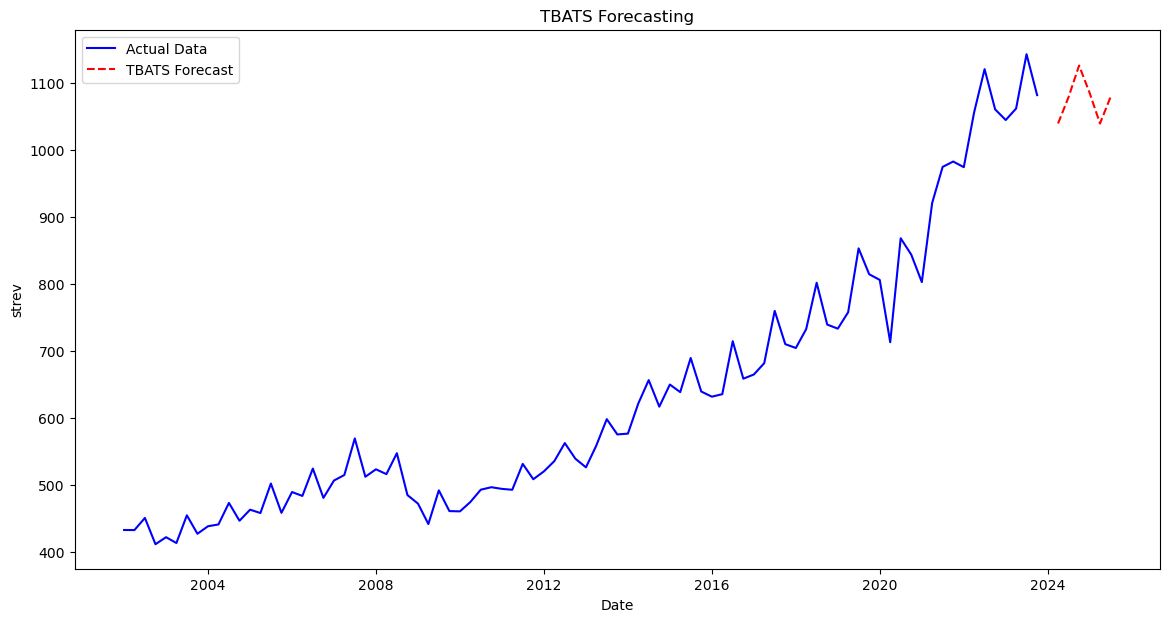

MAE: 23.4194
MAPE: 3.66%


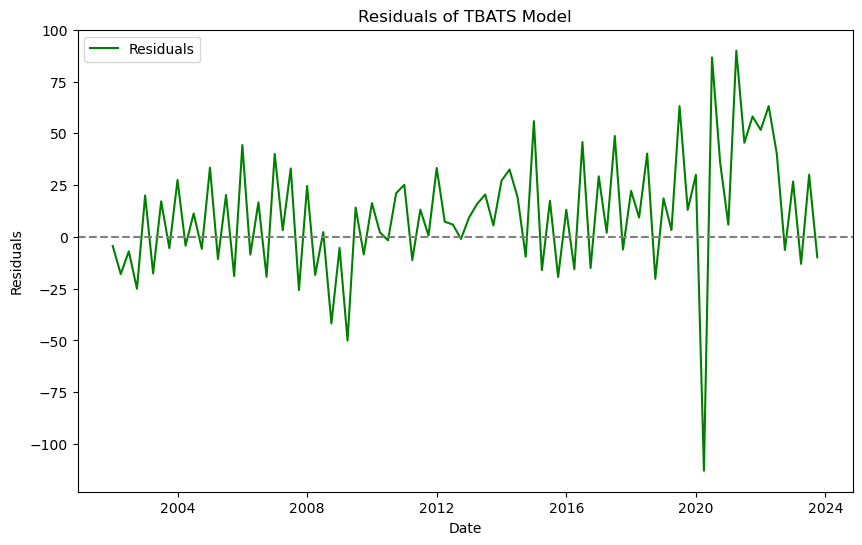

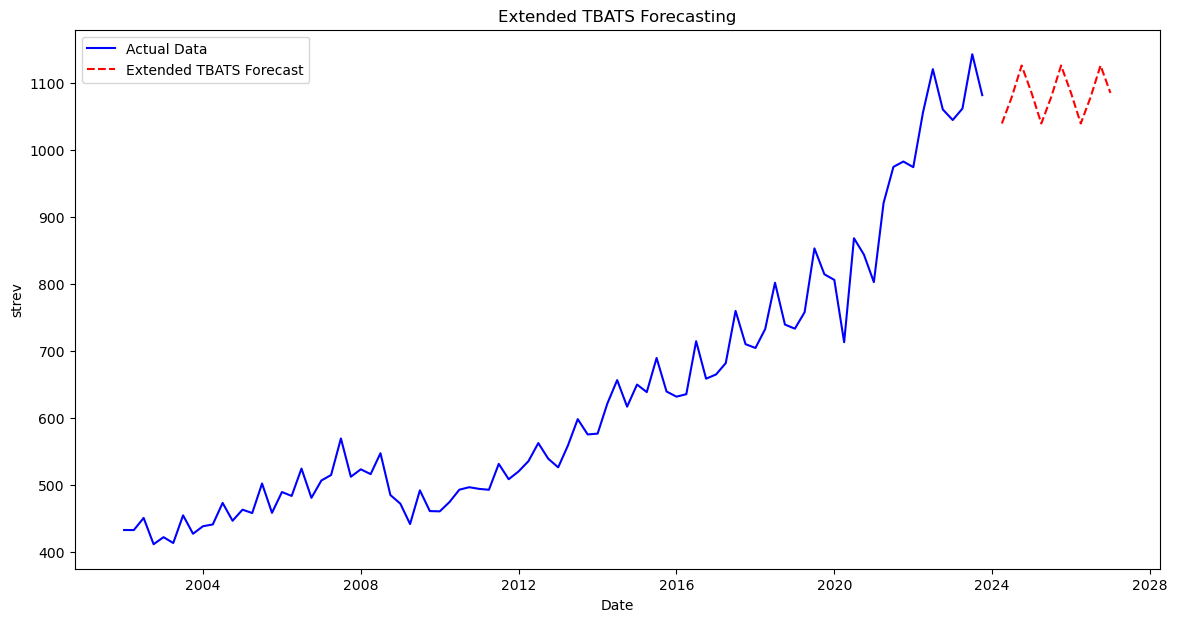

Extended Forecasted values:
2024-03-31: 1039.10
2024-06-30: 1078.28
2024-09-30: 1125.54
2024-12-31: 1084.65
2025-03-31: 1039.10
2025-06-30: 1078.28
2025-09-30: 1125.54
2025-12-31: 1084.65
2026-03-31: 1039.10
2026-06-30: 1078.28
2026-09-30: 1125.54
2026-12-31: 1084.65


In [38]:
# Fit the TBATS model
estimator = TBATS(seasonal_periods=(4,))  # Quarterly data
model_tbats = estimator.fit(cleaned_df['strev'])

# Print model summary
print(model_tbats.summary())

# Forecast future periods
num_forecast_steps = 6  # Adjust number of steps according to needs
forecast_tbats = model_tbats.forecast(steps=num_forecast_steps)

# Generating future dates for the forecast
future_dates = pd.date_range(start=cleaned_df.index[-1], periods=num_forecast_steps + 1, freq='Q')[1:]

# Plot the historical data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(future_dates, forecast_tbats, label='TBATS Forecast', linestyle='--', color='red')
plt.title('TBATS Forecasting')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Calculate fitted values from the model
fitted_values_tbats = model_tbats.y_hat

# Calculate residuals
residuals_tbats = cleaned_df['strev'] - fitted_values_tbats

# Calculate MAE and MAPE
mae_tbats = np.mean(np.abs(residuals_tbats))
mape_tbats = np.mean(np.abs(residuals_tbats / cleaned_df['strev'])) * 100

print(f"MAE: {mae_tbats:.4f}")
print(f"MAPE: {mape_tbats:.2f}%")

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(cleaned_df.index, residuals_tbats, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of TBATS Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Extended forecasting for visibility
extended_forecast_tbats = model_tbats.forecast(steps=12)

# Generating extended future dates for the forecast
extended_future_dates = pd.date_range(start=future_dates[-1], periods=7, freq='Q')[1:]

# Combine future dates for a full extended forecast plot
all_future_dates = future_dates.append(extended_future_dates)

# Plot the extended forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['strev'], label='Actual Data', color='blue')
plt.plot(all_future_dates, extended_forecast_tbats, label='Extended TBATS Forecast', color='red', linestyle='--')
plt.title('Extended TBATS Forecasting')
plt.xlabel('Date')
plt.ylabel('strev')
plt.legend()
plt.show()

# Print forecasted values
print("Extended Forecasted values:")
for date, value in zip(all_future_dates, extended_forecast_tbats):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [4.]
Seasonal harmonics [1]
ARMA errors (p, q): (2, 2)
Smoothing (Alpha): 0.375350
Seasonal Parameters (Gamma): [-3.05066082e-06  6.12857099e-06]
AR coefficients [6.12857099e-06 9.06722091e-01]
MA coefficients [ 0.27337742 -0.41168398]
Seed vector [ 6.12077986e+00 -3.99552291e-02 -2.94605758e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC -155.762032


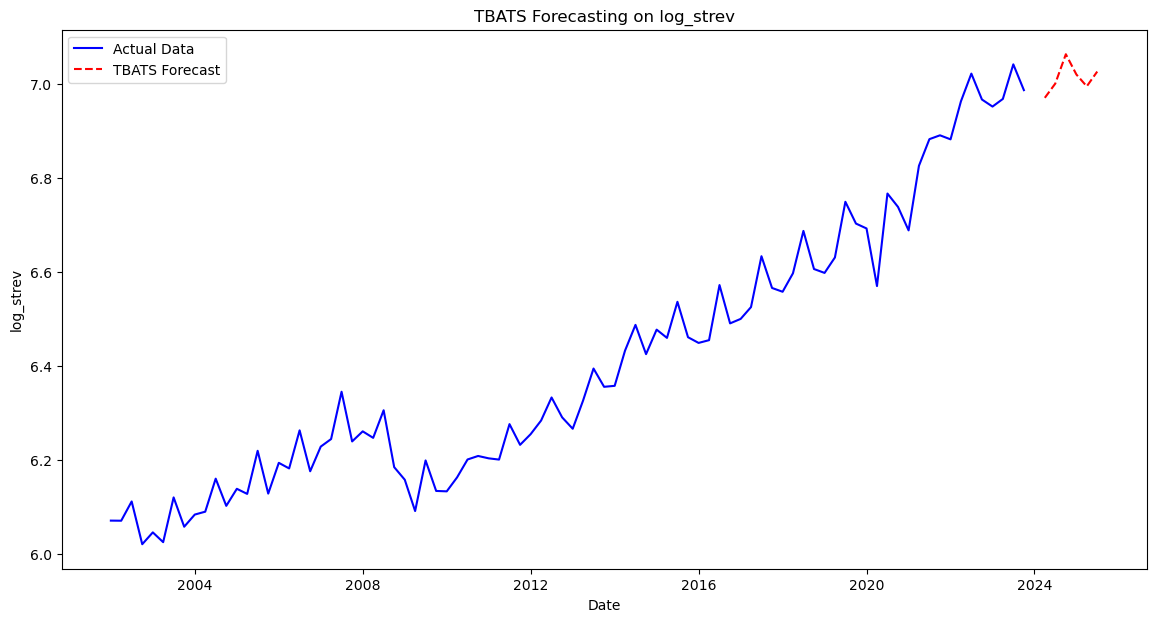

MAE: 0.0283
MAPE: 0.44%


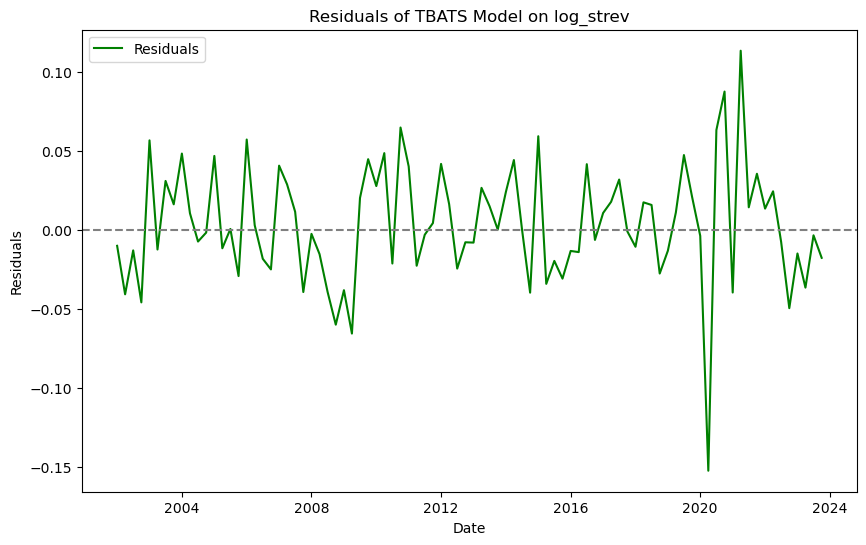

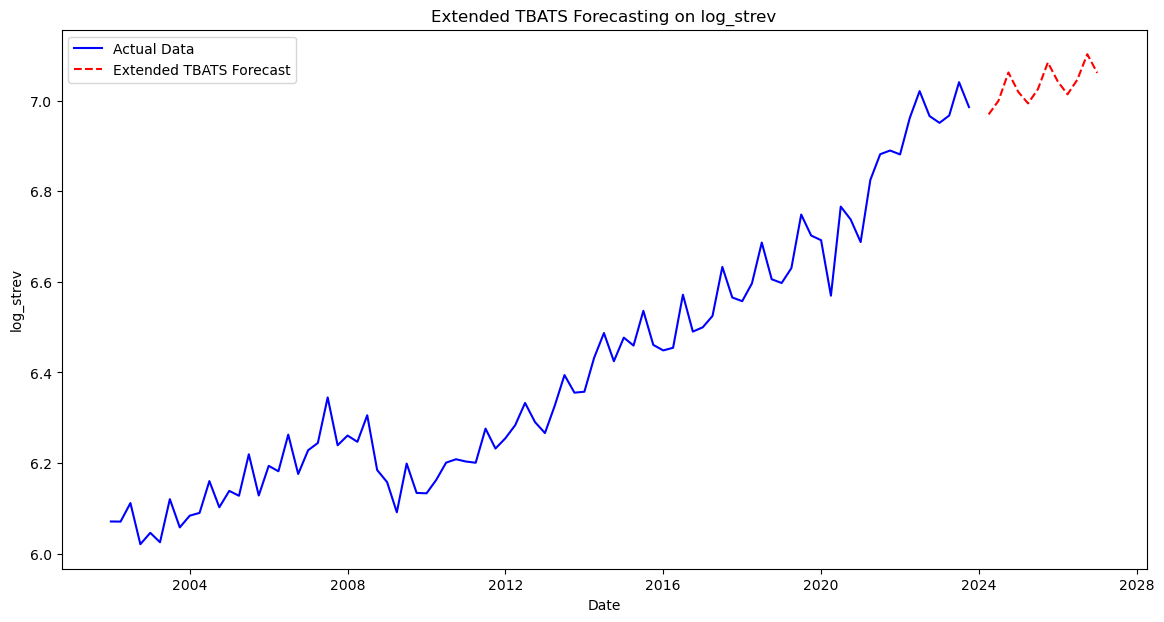

Extended Forecasted values:
2024-03-31: 6.97
2024-06-30: 7.00
2024-09-30: 7.06
2024-12-31: 7.02
2025-03-31: 6.99
2025-06-30: 7.03
2025-09-30: 7.08
2025-12-31: 7.04
2026-03-31: 7.01
2026-06-30: 7.05
2026-09-30: 7.10
2026-12-31: 7.06
Forecasted logged values for upcoming quarters:
2024-03-31: 6.9697
2024-06-30: 6.9999
2024-09-30: 7.0624
2024-12-31: 7.0193
2025-03-31: 6.9941
2025-06-30: 7.0255
2025-09-30: 7.0845
2025-12-31: 7.0425
2026-03-31: 7.0141
2026-06-30: 7.0466
2026-09-30: 7.1027
2026-12-31: 7.0615

Forecasted values on original scale for upcoming quarters:
2024-03-31: 1063.91
2024-06-30: 1096.57
2024-09-30: 1167.26
2024-12-31: 1117.95
2025-03-31: 1090.18
2025-06-30: 1124.99
2025-09-30: 1193.36
2025-12-31: 1144.20
2026-03-31: 1112.26
2026-06-30: 1148.92
2026-09-30: 1215.25
2026-12-31: 1166.24
Forecasted Sales Tax Revenue for FY 2024: 2160.48
Forecasted Sales Tax Revenue for FY 2025: 4500.39
Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): 4384.

<Figure size 1000x600 with 0 Axes>

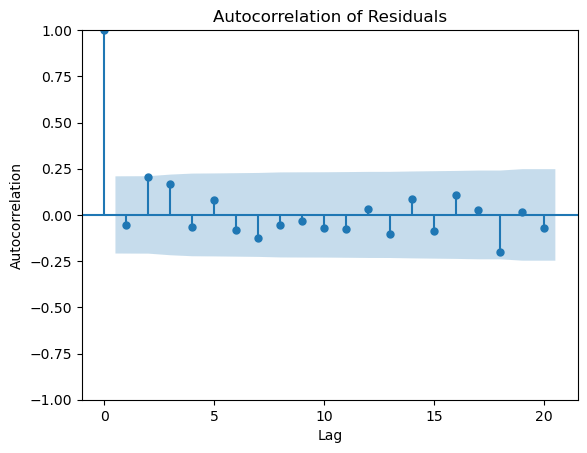

In [39]:
# Fit the TBATS model using log_strev
estimator = TBATS(seasonal_periods=(4,), use_box_cox=False)  # Disable Box-Cox as data is already transformed
model_tbats = estimator.fit(cleaned_df['log_strev'])

# Print model summary
print(model_tbats.summary())

# Forecast future periods
num_forecast_steps = 6  # Adjust number of steps according to needs
forecast_tbats = model_tbats.forecast(steps=num_forecast_steps)

# Generating future dates for the forecast
future_dates = pd.date_range(start=cleaned_df.index[-1], periods=num_forecast_steps + 1, freq='Q')[1:]

# Plot the historical data and forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['log_strev'], label='Actual Data', color='blue')
plt.plot(future_dates, forecast_tbats, label='TBATS Forecast', linestyle='--', color='red')
plt.title('TBATS Forecasting on log_strev')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Calculate fitted values from the model
fitted_values_tbats = model_tbats.y_hat

# Calculate residuals
residuals_tbats = cleaned_df['log_strev'] - fitted_values_tbats

# Calculate MAE and MAPE
mae_tbats = np.mean(np.abs(residuals_tbats))
mape_tbats = np.mean(np.abs(residuals_tbats / cleaned_df['log_strev'])) * 100

print(f"MAE: {mae_tbats:.4f}")
print(f"MAPE: {mape_tbats:.2f}%")

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(cleaned_df.index, residuals_tbats, label='Residuals', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of TBATS Model on log_strev')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Extended forecasting for visibility
extended_forecast_tbats = model_tbats.forecast(steps=12)

# Generating extended future dates for the forecast
extended_future_dates = pd.date_range(start=future_dates[-1], periods=7, freq='Q')[1:]

# Combine future dates for a full extended forecast plot
all_future_dates = future_dates.append(extended_future_dates)

# Plot the extended forecasts
plt.figure(figsize=(14, 7))
plt.plot(cleaned_df.index, cleaned_df['log_strev'], label='Actual Data', color='blue')
plt.plot(all_future_dates, extended_forecast_tbats, label='Extended TBATS Forecast', color='red', linestyle='--')
plt.title('Extended TBATS Forecasting on log_strev')
plt.xlabel('Date')
plt.ylabel('log_strev')
plt.legend()
plt.show()

# Print forecasted values
print("Extended Forecasted values:")
for date, value in zip(all_future_dates, extended_forecast_tbats):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")
    
    
# Print forecasted logged values for upcoming quarters
print("Forecasted logged values for upcoming quarters:")
for date, value in zip(all_future_dates, extended_forecast_tbats):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.4f}")

# Applying exponential to convert logged values back to the original scale
inverse_log_forecast = np.exp(extended_forecast_tbats)

# Print the original scale forecasted values
print("\nForecasted values on original scale for upcoming quarters:")
for date, value in zip(all_future_dates, inverse_log_forecast):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

# Dates and forecasted values
forecast_dates = pd.DatetimeIndex(all_future_dates)
forecast_values = np.exp(extended_forecast_tbats)  # Inversing the log to get original scale values

# Creating a DataFrame for ease of manipulation
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Values': forecast_values})

# Summing values for Fiscal Year 2024 (Second half of 2023 and First half of 2024)
fy_2024 = forecast_df[(forecast_df['Date'] >= '2023-07-01') & (forecast_df['Date'] < '2024-07-01')]['Forecast_Values'].sum()

# Summing values for Fiscal Year 2025 (Second half of 2024 and First half of 2025)
fy_2025 = forecast_df[(forecast_df['Date'] >= '2024-07-01') & (forecast_df['Date'] < '2025-07-01')]['Forecast_Values'].sum()

# Print the summed forecasted values for fiscal years
print(f"Forecasted Sales Tax Revenue for FY 2024: {fy_2024:.2f}")
print(f"Forecasted Sales Tax Revenue for FY 2025: {fy_2025:.2f}")

# Assuming observed data might include up to 2023-07-01
observed_fy_2024 = cleaned_df[(cleaned_df.index >= '2023-07-01') & (cleaned_df.index < '2024-01-01')]['log_strev'].apply(np.exp).sum()

# Summing forecasted values for First half of 2024
forecasted_fy_2024 = forecast_df[(forecast_df['Date'] >= '2024-01-01') & (forecast_df['Date'] < '2024-07-01')]['Forecast_Values'].sum()

# Total Fiscal Year 2024 revenue includes observed and forecasted values
total_fy_2024_revenue = observed_fy_2024 + forecasted_fy_2024

# Print the summed forecasted values for fiscal year 2024 including observed values
print(f"Forecasted Sales Tax Revenue for FY 2024 (including observed values for Q3 & Q4 2023): {total_fy_2024_revenue:.2f}")


# Plot ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=20, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()